In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from astropy.table import Table, join, QTable, vstack
import astropy.units as u
import sys
import pyneb as pn
from multiprocessing import Pool
import multiprocessing as mp
import math
from astropy.io import fits
from orcs.process import SpectralCube

from astropy.nddata import NDData, Cutout2D
from astropy.wcs import WCS

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

from reproject import reproject_interp
import reproject
from regions import PixCoord

import pylab as pl

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import griddata

from orb.fit import fit_lines_in_spectrum
from orb.utils.spectrum import corr2theta, amp_ratio_from_flux_ratio
from orb.core import Lines
import gvar
import orb

import extinction
from extinction import apply, remove

from photutils.detection import DAOStarFinder

import aplpy
import seaborn as sns

from skimage import filters

import statsmodels.api as sm
from scipy.stats import spearmanr

import sys
sys.path.append("/home/habjan/SITELLE/sitelle_metallicities")
import analysis_functions as af

### Import data

In [3]:
products_data_path = '/home/habjan/SITELLE/data/data_products'
inter_data_path = '/home/habjan/SITELLE/data/data_raw_intermediate'

sit_0628 = fits.open(products_data_path + f"/NGC0628_SITELLE.fits")
OII_0628_mp = fits.open(products_data_path + f"/NGC0628_OII_map_mp.fits")[0]
OII_0628 = fits.open(products_data_path + f"/NGC0628_OII_map.fits")[0]
mask_0628 = fits.open(inter_data_path + f"/NGC0628_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC0628_physdata_MUSE+SITELLE.fits','rb')
data_0628 = Table.read(infile)
infile = inter_data_path + f"/NGC0628_cube.hdf5"
cube_0628 = SpectralCube(infile)
sit_0628_mp = fits.open(products_data_path + f"/NGC0628_SITELLE_mp.fits")

sit_2835 = fits.open(products_data_path + f"/NGC2835_SITELLE.fits")
#OII_2835_mp = fits.open(f"/NGC2835_OII_map_mp.fits")[0]
OII_2835 = fits.open(products_data_path + f"/NGC2835_OII_map.fits")[0]
mask_2835 = fits.open(inter_data_path + f"/NGC2835_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC2835_physdata_MUSE+SITELLE.fits','rb')
data_2835 = Table.read(infile)
infile = inter_data_path + f"/NGC2835_cube.hdf5"
cube_2835 = SpectralCube(infile)

sit_3351 = fits.open(products_data_path + f"/NGC3351_SITELLE.fits")
#OII_3351_mp = fits.open(f"/NGC3351_OII_map_mp.fits")[0]
OII_3351 = fits.open(products_data_path + f"/NGC3351_OII_map.fits")[0]
mask_3351 = fits.open(inter_data_path + f"/NGC3351_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC3351_physdata_MUSE+SITELLE.fits','rb')
data_3351 = Table.read(infile)
infile = inter_data_path + f"/NGC3351_cube.hdf5"
cube_3351 = SpectralCube(infile)

sit_4535 = fits.open(products_data_path + f"/NGC4535_SITELLE.fits")
#OII_4535_mp = fits.open(f"/NGC4535_OII_map_mp.fits")[0]
OII_4535 = fits.open(products_data_path + f"/NGC4535_OII_map.fits")[0]
mask_4535 = fits.open(inter_data_path + f"/NGC4535_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC4535_physdata_MUSE+SITELLE.fits','rb')
data_4535 = Table.read(infile)
infile = inter_data_path + f"/NGC4535_cube.hdf5"
cube_4535 = SpectralCube(infile)

sit_3627 = fits.open(products_data_path + f"/NGC3627_SITELLE.fits")
#OII_4535_mp = fits.open(f"/NGC4535_OII_map_mp.fits")[0]
#OII_3627 = fits.open(f"/NGC3627_OII_map.fits")[0]
mask_3627 = fits.open(inter_data_path + f"/NGC3627_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC3627_physdata_MUSE+SITELLE.fits','rb')
data_3627 = Table.read(infile)
infile = inter_data_path + f"/NGC3627_cube.hdf5"
cube_3627 = SpectralCube(infile)

table_dic = {1: data_0628, 2:data_2835, 3:data_3351, 4:data_4535, 5:data_3627}

old cube architecture (level 1). IO performances could be reduced.
Cube is level 1


shape: (2048, 2064, 105)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 223)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 171)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 222)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 128)
wavenumber calibration: True
flux calibration: True
wcs calibration: False


### Make SITELLE deep frames

In [4]:
sit_deep_0628 = fits.PrimaryHDU(data=np.transpose(cube_0628.get_deep_frame().data), header=OII_0628.header)
sit_deep_2835 = fits.PrimaryHDU(data=np.transpose(cube_2835.get_deep_frame().data), header=OII_2835.header)
sit_deep_3351 = fits.PrimaryHDU(data=np.transpose(cube_3351.get_deep_frame().data), header=OII_3351.header)
sit_deep_4535 = fits.PrimaryHDU(data=np.transpose(cube_4535.get_deep_frame().data), header=OII_4535.header)
sit_deep_3627 = fits.PrimaryHDU(data=np.transpose(cube_3627.get_deep_frame().data), header=WCS(cube_3627.get_header(), naxis=2).to_header())

In [6]:
trunc = 4

deep_ind = np.where((sit_0628[1].data < 1/(10**-8 * 3650)) & (sit_0628[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_0628[0].data[deep_ind], axis=0)
smoothed_0628 = filters.gaussian(deep_arr, sigma=1, truncate=trunc, preserve_range=False)
sit_deep_0628 = fits.PrimaryHDU(data=smoothed_0628, header=OII_0628.header)

deep_ind = np.where((sit_2835[1].data < 1/(10**-8 * 3650)) & (sit_2835[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_2835[0].data[deep_ind], axis=0)
smoothed_2835 = filters.gaussian(deep_arr, sigma=2, truncate=trunc, preserve_range=False)
sit_deep_2835 = fits.PrimaryHDU(data=smoothed_2835, header=OII_2835.header)

deep_ind = np.where((sit_3351[1].data < 1/(10**-8 * 3650)) & (sit_3351[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_3351[0].data[deep_ind], axis=0)
smoothed_3351 = filters.gaussian(deep_arr, sigma=2, truncate=trunc, preserve_range=False)
sit_deep_3351 = fits.PrimaryHDU(data=smoothed_3351, header=OII_3351.header)

deep_ind = np.where((sit_4535[1].data < 1/(10**-8 * 3650)) & (sit_4535[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_4535[0].data[deep_ind], axis=0)
smoothed_4535 = filters.gaussian(deep_arr, sigma=3, truncate=trunc, preserve_range=False)
sit_deep_4535 = fits.PrimaryHDU(data=smoothed_4535, header=OII_4535.header)

### Figure 1: all five SITELLE deep frames

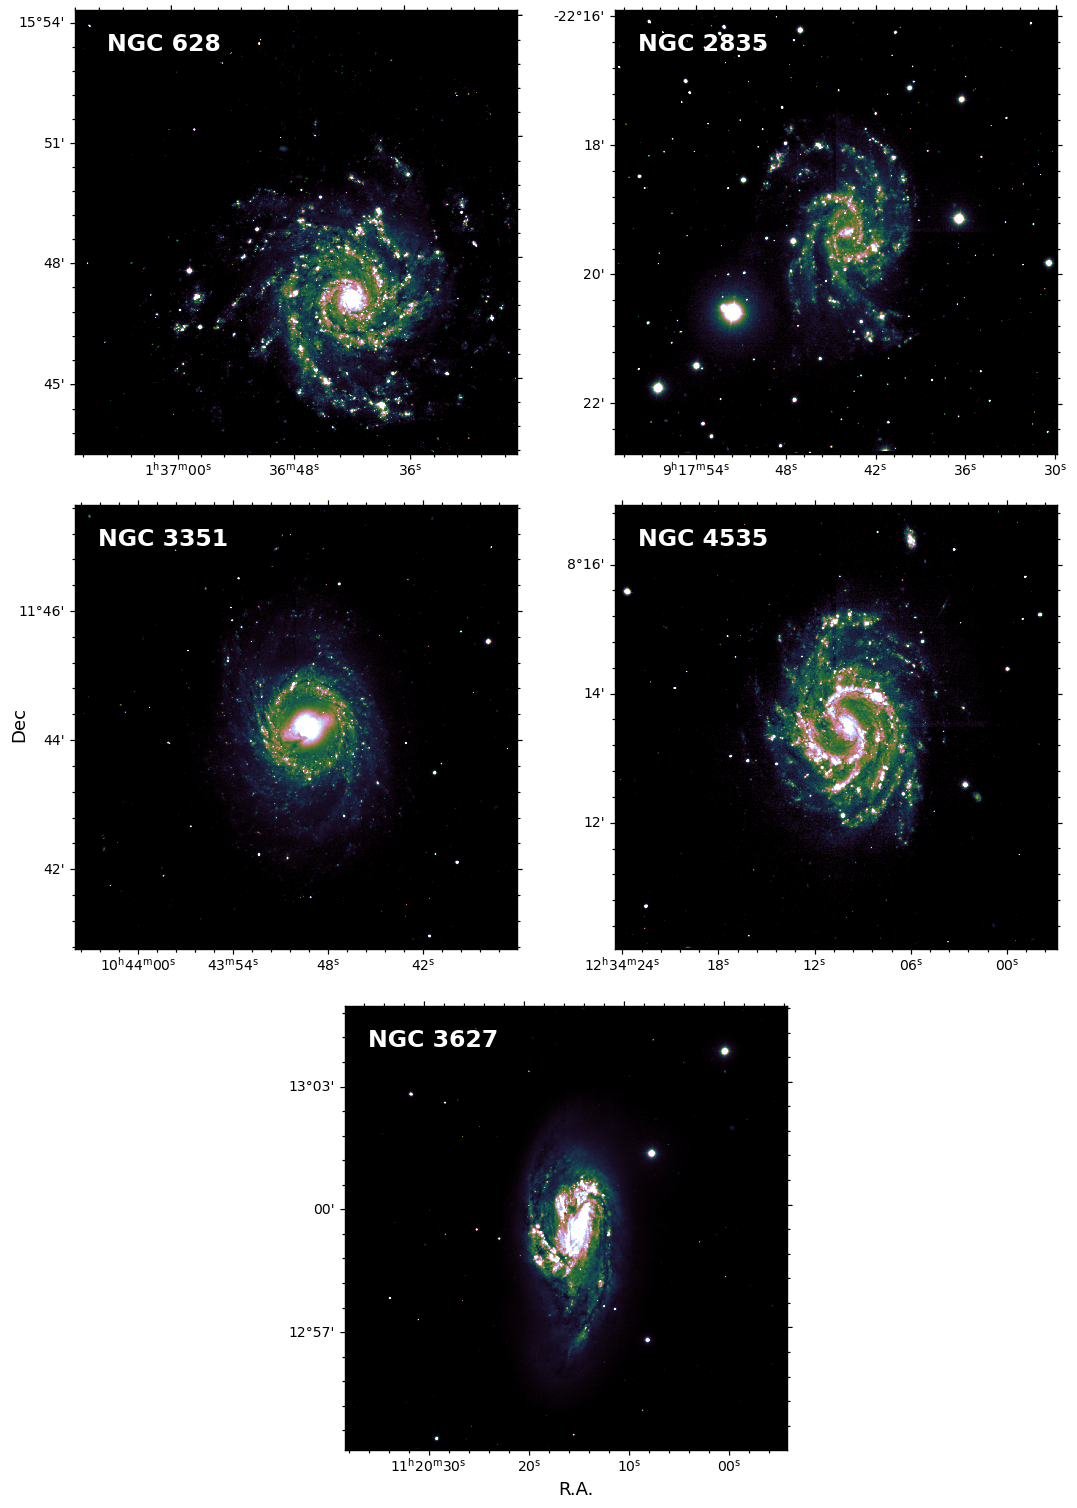

In [5]:
fig = plt.figure(figsize=(13, 6))
cmap = 'cubehelix'

up = 0.9955
low = 0.7

dx = 0.34
dy = 0.74

fs = 17

f1 = aplpy.FITSFigure(sit_deep_0628, figure=fig, subplot=[0.1,0.1, dx, dy])
#f1.recenter(coord_dic['NGC0628'][0], coord_dic['NGC0628'][1], width=zoom_dic['NGC0628'][0], height=zoom_dic['NGC0628'][0])
f1.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_0628.data, low), vmax=np.quantile(sit_deep_0628.data, up))
f1.add_label(0.2, 0.925,'NGC 628', relative=True, color='white', weight='bold', size=fs)
f1.axis_labels.hide_x()
f1.axis_labels.hide_y()

f2 = aplpy.FITSFigure(sit_deep_2835, figure=fig, subplot=[0.515,0.1,dx,dy])
#f2.recenter(coord_dic['NGC2835'][0], coord_dic['NGC2835'][1], width=zoom_dic['NGC2835'][0], height=zoom_dic['NGC2835'][0])
f2.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_2835.data, low), vmax=np.quantile(sit_deep_2835.data, up))
f2.add_label(0.2, 0.925,'NGC 2835', relative=True, color='white', weight='bold', size=fs)
f2.axis_labels.hide_x()
f2.axis_labels.hide_y()

f3 = aplpy.FITSFigure(sit_deep_3351, figure=fig, subplot=[0.1,-0.725,dx,dy])
#f3.recenter(coord_dic['NGC3351'][0], coord_dic['NGC3351'][1], width=zoom_dic['NGC3351'][0], height=zoom_dic['NGC3351'][0])
f3.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_3351.data, low), vmax=np.quantile(sit_deep_3351.data, up+0.002))
f3.add_label(0.2, 0.925,'NGC 3351', relative=True, color='white', weight='bold', size=fs)
f3.axis_labels.hide_x()
f3.axis_labels.hide_y()

f4 = aplpy.FITSFigure(sit_deep_4535, figure=fig, subplot=[0.515, -0.725,dx,dy])
#f4.recenter(coord_dic['NGC4535'][0], coord_dic['NGC4535'][1], width=zoom_dic['NGC4535'][0], height=zoom_dic['NGC4535'][0])
f4.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_4535.data, low), vmax=np.quantile(sit_deep_4535.data, up))
f4.add_label(0.2, 0.925,'NGC 4535', relative=True, color='white', weight='bold', size=fs)
f4.axis_labels.hide_x()
f4.axis_labels.hide_y()

f4 = aplpy.FITSFigure(sit_deep_3627, figure=fig, subplot=[0.3075, -1.56, dx,dy])
#f4.recenter(coord_dic['NGC4535'][0], coord_dic['NGC4535'][1], width=zoom_dic['NGC4535'][0], height=zoom_dic['NGC4535'][0])
f4.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_3627.data, low), vmax=np.quantile(sit_deep_3627.data, up))
f4.add_label(0.2, 0.925,'NGC 3627', relative=True, color='white', weight='bold', size=fs)
f4.axis_labels.hide_x()
f4.axis_labels.hide_y()

fig.supxlabel('R.A.', x =0.485, y=-1.64, fontsize=13)
fig.supylabel('Dec', x =0.05, y=-0.35, fontsize=13)

fig.savefig("/home/habjan/SITELLE/sitelle_metallicities/figures/sitelle_deepframes.png", bbox_inches="tight")

### Make array of high SNR velocity values and then interpolate this map using nearest neighbors

In [7]:
snr = 5
high_vel_ind = np.where(data_0628['OII3727_FLUX_CORR'] / data_0628['OII3727_FLUX_CORR_ERR'] > snr)[0]

vel_mask = np.zeros(mask_0628.data.shape)
for i in high_vel_ind:
    vel_mask[mask_0628.data == i] = data_0628['OII3727_VEL'][i]

x, y = np.where(vel_mask != 0)
x_grid, y_grid = np.meshgrid(np.arange(vel_mask.shape[0]), np.arange(vel_mask.shape[1]))
vel_smoothed = griddata(points = (x, y), values = vel_mask[np.where(vel_mask != 0)], xi=(x_grid, y_grid), method='nearest')
vel_map_0628 = fits.PrimaryHDU(data=vel_smoothed, header=mask_0628.header)

### Plot the regular velocity map

Text(0.5, 1.0, 'NGC 628 Velocity Plot')

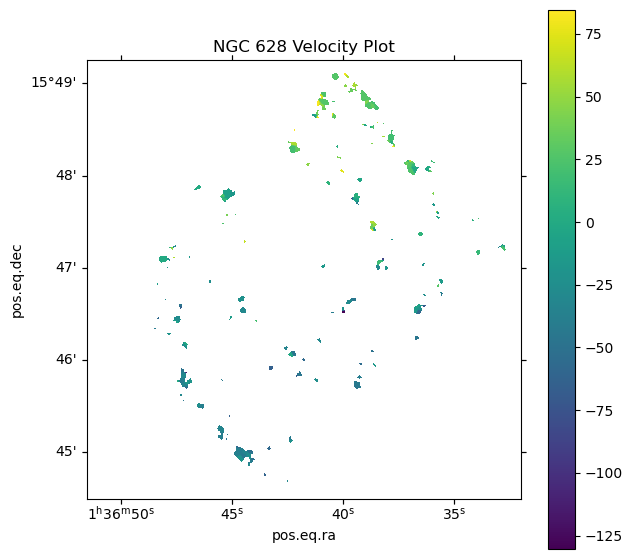

: 

: 

In [ ]:
nan_vel = np.copy(vel_mask)
nan_vel[nan_vel == 0] = np.nan 

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(vel_map_0628.header))

im = ax.imshow(nan_vel, vmin=np.nanquantile(nan_vel, 0), vmax=np.nanquantile(nan_vel, 1))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Velocity Plot')

### Plot the smoothed velocity map

Text(0.5, 1.0, 'NGC 628 Smoothed Velocity Plot')

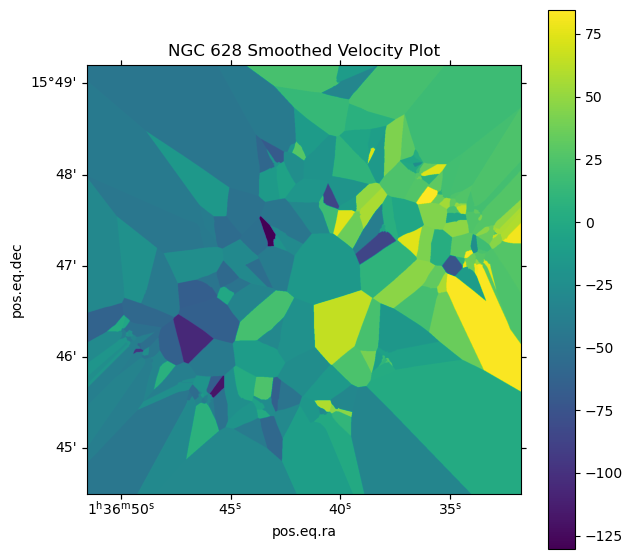

: 

In [ ]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(vel_map_0628.header))

im = ax.imshow(vel_map_0628.data, vmin=np.nanquantile(vel_map_0628.data, 0), vmax=np.nanquantile(vel_map_0628.data, 1))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Smoothed Velocity Plot')

### Use the smoothed velocity map to make a smoothed OII map

In [ ]:
wave3729 = 3728.815
c = 299792
galvel = 651

up_down = 15

test = fits.open(inter_data_path + f"/NGC0628_SITELLE_mp.fits")

### Go from Velocities to wavenumber
red3729 = 1/((wave3729*(vel_map_0628.data+galvel)/(c) + wave3729) * 10**-8)
### Make a 3d boolean above and below the peak of [OII]3727
wave_bool = (red3729 + up_down > sit_0628[1].data[:, None, None]) & (red3729 - up_down < sit_0628[1].data[:, None, None])
### make a masked array of where [OII]3727 is at each point in the cube
#cube_masked = np.ma.masked_array(sit_0628_mp[0].data, ~wave_bool)
cube_masked = np.ma.masked_array(test[0].data, ~wave_bool)
### sum over all wavelength channels
oii_map_sum = np.nansum(cube_masked, axis=0)
### Smooth the OII map 
oii_smoothed = filters.gaussian(oii_map_sum, sigma=1.5)
### Save as a fits file
oii_map = fits.PrimaryHDU(data=oii_smoothed, header=mask_0628.header)

: 

### Plot the OII map in imshow

Text(0.5, 1.0, 'NGC 628 Smoothed OII map')

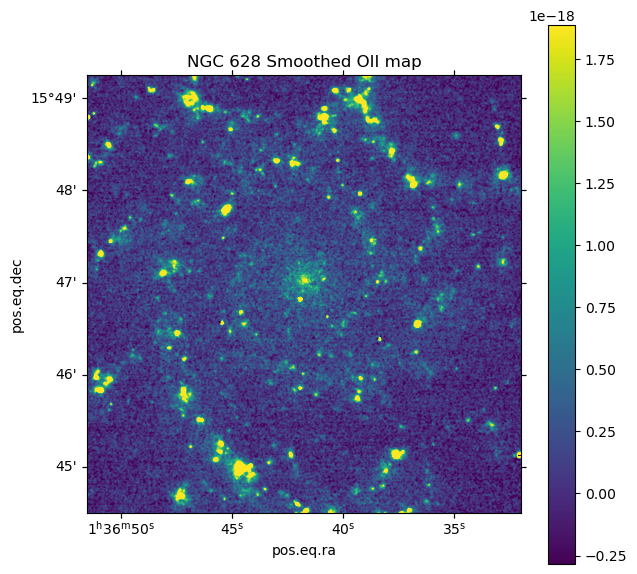

: 

In [ ]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(mask_0628.header))

im = ax.imshow(oii_map.data, vmin=np.nanquantile(oii_map.data, 0.01), vmax=np.nanquantile(oii_map.data, 0.99))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Smoothed OII map')

### Firgure 2: OII map with HII region mask overlaid

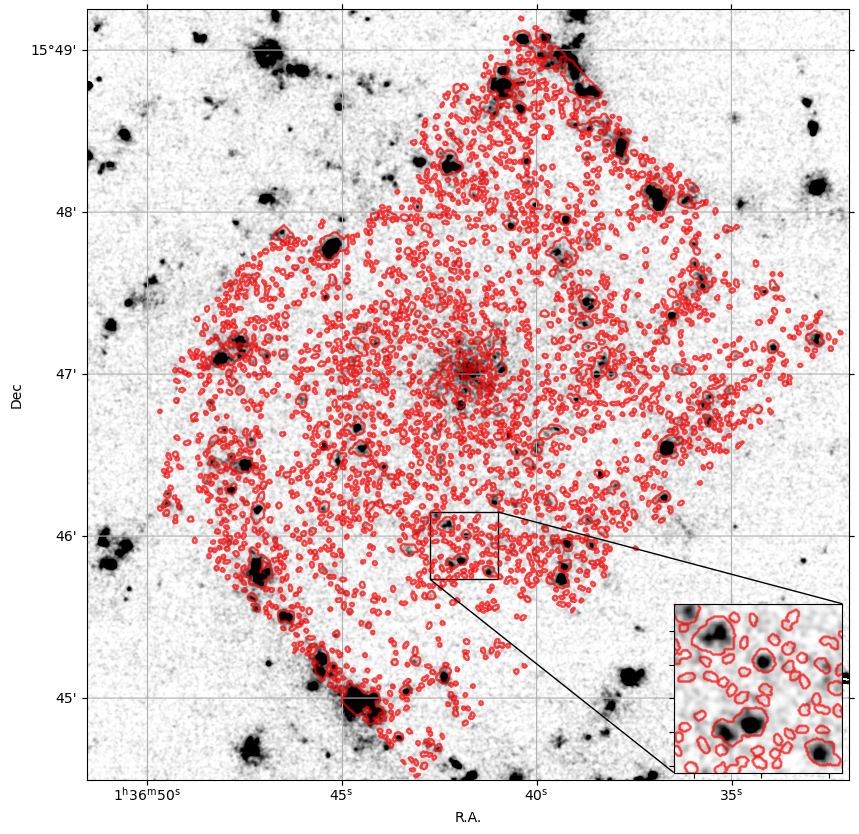

: 

In [ ]:
#reg1, reg2 = 184, 311

hii_mask = np.copy(mask_0628.data)
#hii_mask[hii_mask == reg1] = 10**4
#hii_mask[hii_mask == reg2] = 10**4
#hii_mask[hii_mask < 10**3.9] = -1

hii_mask[hii_mask > 0] = 10**4

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=WCS(mask_0628.header))

ax.imshow(oii_map.data, cmap='Greys', vmin=np.nanquantile(oii_map.data, 0.1), vmax=np.nanquantile(oii_map.data, 0.985))
ax.contour(hii_mask, colors='red', alpha=0.17)
ax.update({'xlabel': 'R.A.', 'ylabel': 'Dec'})
ax.grid(False)

axins = zoomed_inset_axes(ax, 2.5, loc=4)
axins.imshow(oii_map.data, cmap='Greys', vmin=np.nanquantile(oii_map.data, 0.1), vmax=np.nanquantile(oii_map.data, 0.985))
axins.contour(hii_mask, colors='red', alpha=0.17)

lim_dic = {'NGC4535':[475, 575, 750, 850], 'NGC3351':[325, 450, 735, 860], 'NGC2835':[600, 700, 275, 375] ,'NGC0628':[635, 760, 370, 495]}

galaxy = 'NGC0628'

axins.set_xlim(lim_dic[galaxy][0], lim_dic[galaxy][1])
axins.set_ylim(lim_dic[galaxy][2], lim_dic[galaxy][3])

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.grid(False)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.0")
plt.draw()
plt.show()

# Spectral Fitting plots

### Figure 3: [OII]3727 fits at different SNR

Region 22 with SNR 50.067268381545006
Region 26 with SNR 11.55894958993864
Region 137 with SNR 3.5818154597773666


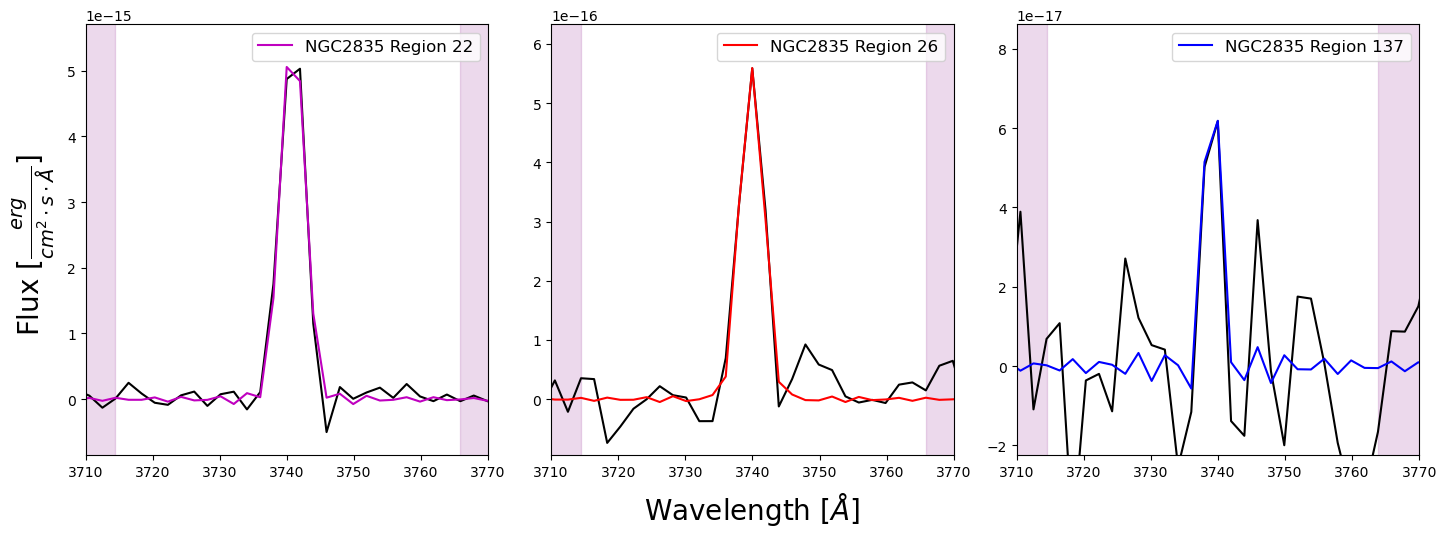

: 

In [ ]:
galaxynum = 4
galdic = {1:'NGC4254', 2:'NGC4535', 3:'NGC3351', 4:'NGC2835', 5:'NGC0628', 6:'NGC3627'}  #There is no SITELLE data for NGC 4254, NGC 2835 has the best data 
galaxy = galdic[galaxynum]

galveldic = {'NGC4254': 2388 , 'NGC4535': 1954  , 'NGC3351': 775, 'NGC2835': 867, 'NGC0628':651, 'NGC3627':715}
galvel = galveldic[galaxy]

hdul = fits.open(f'/home/habjan/SITELLE/sandbox_notebooks/pdf_fit_plotting/{galaxy}_spectra_fitting.fits')

infile = open(inter_data_path + f'/{galaxy}_refit+SITELLEfits_data.fits','rb')
data = Table.read(infile)

sitlam = hdul[0].data
sitspec = hdul[1].data

fit3727 = hdul[2].data
snr3727 = hdul[3].data

wave_surr = 50
flux_bottom = 10**-0.6
flux_top = 1.1
x_min = 3710
x_max = 3770

fig, (ax1, ax2, ax3)  = plt.subplots(1, 3)#, sharey='row')
fig.set_figheight(5)
fig.set_figwidth(14)

### Plot 1

reg = np.where(np.nanmax(snr3727) == snr3727)[0][0]

print(f'Region {reg} with SNR {snr3727[reg]}')

inspectrum = sitspec[reg]
inspectrum[np.isnan(inspectrum)] = 0

wave3729 = 3728.815
c = 299792
red3729 = 1/((wave3729*(data[reg]['HA6562_VEL']+galvel)/(c) + wave3729) * 10**-8)

n1 = [np.where(sitlam > red3729 - 450)[0][0],np.where(sitlam > red3729 - 175)[0][0]]
n2 = [np.where(sitlam > red3729 + 175)[0][0], np.where(sitlam > red3729 + 700)[0][0]]

fit_lam = np.concatenate([sitlam[n2[0]:n2[1]], sitlam[n1[0]:n1[1]]])
fit_spec = np.concatenate([inspectrum[n2[0]:n2[1]], inspectrum[n1[0]:n1[1]]])
s_fit = np.polyfit(fit_lam, fit_spec, 1)
sfit_func = np.poly1d(s_fit)

noisestd = (np.std(inspectrum[n1[0]:n1[1]]) + np.std(inspectrum[n2[0]:n2[1]])) / 2
inspectrum = inspectrum - sfit_func(sitlam)

flux = np.array(data['OII3727_FLUX_CORR'])[reg]

ax1.plot(1/(10**-8*sitlam), inspectrum, c='k')#, label='spectrum')
ax1.plot(1/(10**-8*sitlam), fit3727[reg], c='m', label=f'{galaxy} Region {reg}')
ax1.legend(fontsize=12, loc='upper right')


#ax1.set_title(f'Region {reg} | SNR: {round(snr3727[reg], 2)}')
ax1.set_xlim(x_min, x_max)
max_spec = np.nanmax(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
min_spec = np.nanmin(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
ax1.set_ylim(min_spec*flux_bottom * 10, max_spec*flux_top)
ax1.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 - 450)[0][0]:np.where(sitlam > red3729 - 175)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax1.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 + 175)[0][0]:np.where(sitlam > red3729 + 700)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)

### Plot 2

reg = np.where((snr3727 > 10) & (snr3727 < 15))[0][0]
print(f'Region {reg} with SNR {snr3727[reg]}')

inspectrum = sitspec[reg]
inspectrum[np.isnan(inspectrum)] = 0

wave3729 = 3728.815
c = 299792
red3729 = 1/((wave3729*(data[reg]['HA6562_VEL']+galvel)/(c) + wave3729) * 10**-8)

n1 = [np.where(sitlam > red3729 - 450)[0][0],np.where(sitlam > red3729 - 175)[0][0]]
n2 = [np.where(sitlam > red3729 + 175)[0][0], np.where(sitlam > red3729 + 700)[0][0]]

fit_lam = np.concatenate([sitlam[n2[0]:n2[1]], sitlam[n1[0]:n1[1]]])
fit_spec = np.concatenate([inspectrum[n2[0]:n2[1]], inspectrum[n1[0]:n1[1]]])
s_fit = np.polyfit(fit_lam, fit_spec, 1)
sfit_func = np.poly1d(s_fit)

noisestd = (np.std(inspectrum[n1[0]:n1[1]]) + np.std(inspectrum[n2[0]:n2[1]])) / 2
inspectrum = inspectrum - sfit_func(sitlam)

flux = np.array(data['OII3727_FLUX_CORR'])[reg]

ax2.plot(1/(10**-8*sitlam), inspectrum, c='k')#, label='spectrum')
ax2.plot(1/(10**-8*sitlam), fit3727[reg], c='red', label=f'{galaxy} Region {reg}')

#ax2.set_title(f'Region {reg} | SNR: {round(snr3727[reg], 2)}')
ax2.set_xlim(x_min, x_max)
max_spec = np.nanmax(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
min_spec = np.nanmin(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
ax2.set_ylim(min_spec*flux_bottom *3, max_spec*flux_top)
ax2.legend(fontsize=12, loc='upper right')

ax2.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 - 450)[0][0]:np.where(sitlam > red3729 - 175)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax2.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 + 175)[0][0]:np.where(sitlam > red3729 + 700)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)

### Plot 3

reg = np.where((snr3727 > 3) & (snr3727 < 4))[0][12]
print(f'Region {reg} with SNR {snr3727[reg]}')

inspectrum = sitspec[reg]
inspectrum[np.isnan(inspectrum)] = 0

wave3729 = 3728.815
c = 299792
red3729 = 1/((wave3729*(data[reg]['HA6562_VEL']+galvel)/(c) + wave3729) * 10**-8)

n1 = [np.where(sitlam > red3729 - 450)[0][0],np.where(sitlam > red3729 - 175)[0][0]]
n2 = [np.where(sitlam > red3729 + 175)[0][0], np.where(sitlam > red3729 + 700)[0][0]]

fit_lam = np.concatenate([sitlam[n2[0]:n2[1]], sitlam[n1[0]:n1[1]]])
fit_spec = np.concatenate([inspectrum[n2[0]:n2[1]], inspectrum[n1[0]:n1[1]]])
s_fit = np.polyfit(fit_lam, fit_spec, 1)
sfit_func = np.poly1d(s_fit)

noisestd = (np.std(inspectrum[n1[0]:n1[1]]) + np.std(inspectrum[n2[0]:n2[1]])) / 2
inspectrum = inspectrum - sfit_func(sitlam)

flux = np.array(data['OII3727_FLUX_CORR'])[reg]

ax3.plot(1/(10**-8*sitlam), inspectrum, c='k')#, label='spectrum')
ax3.plot(1/(10**-8*sitlam), fit3727[reg], c='blue', label=f'{galaxy} Region {reg}')

#ax3.set_title(f'Region {reg} | SNR: {round(snr3727[reg], 2)}')
ax3.set_xlim(x_min, x_max)
max_spec = np.nanmax(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
min_spec = np.nanmin(sitspec[reg][(sitlam > 1/(3850*10**-8)) & (sitlam < 1/(3650*10**-8))])
ax3.set_ylim(min_spec*flux_bottom * 1.5, max_spec*flux_top)
ax3.legend(fontsize=12, loc='upper right')

ax3.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 - 450)[0][0]:np.where(sitlam > red3729 - 175)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax3.fill_between(1/(10**-8*sitlam)[np.where(sitlam > red3729 + 175)[0][0]:np.where(sitlam > red3729 + 700)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.text(0.5, -0.05, r'Wavelength [$\AA$]', ha='center', fontsize=20)
fig.text(-0.03, 0.5, r'Flux [$\frac{erg}{cm^{2} \cdot s \cdot \AA}$]', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()
#plt.legend()
plt.show()

### Figure 4: auroral line fits

In [ ]:
fit5755 = hdul[6].data
snr5755 = hdul[7].data

fit6312 = hdul[8].data
snr6312 = hdul[9].data

fit7319 = hdul[10].data
snr7319 = hdul[11].data

fit7330 = hdul[12].data
snr7330 = hdul[13].data

hdu1 = fits.open(f'/home/habjan/SITELLE/data/data_raw_intermediate/{galaxy}_VorSpectra.fits')
hdu2 = fits.open(f'/home/habjan/SITELLE/data/data_raw_intermediate/{galaxy}_ppxf-bestfit-emlines.fits')

bestfit_gas = np.ma.MaskedArray( hdu2[1].data["BESTFIT"],
                                mask=hdu2[1].data['BESTFIT']==0)

gas_templ = np.ma.MaskedArray( hdu2[1].data["GAS_BESTFIT"],
                              mask=hdu2[1].data['BESTFIT']==0)

lam = np.exp(hdu1[2].data['LOGLAM'])
log_spec = hdu1[1].data['SPEC']

fluxin = log_spec - (bestfit_gas - gas_templ)

def gaussian(x, a, w0, sigma):    #a:amplitude, wavelength:feature wavelength, sigma:spectral resolution, C:zero offeset
        return a * np.exp((-(x-w0) ** 2)/ (2 * sigma ** 2)) + C + lp*x

: 

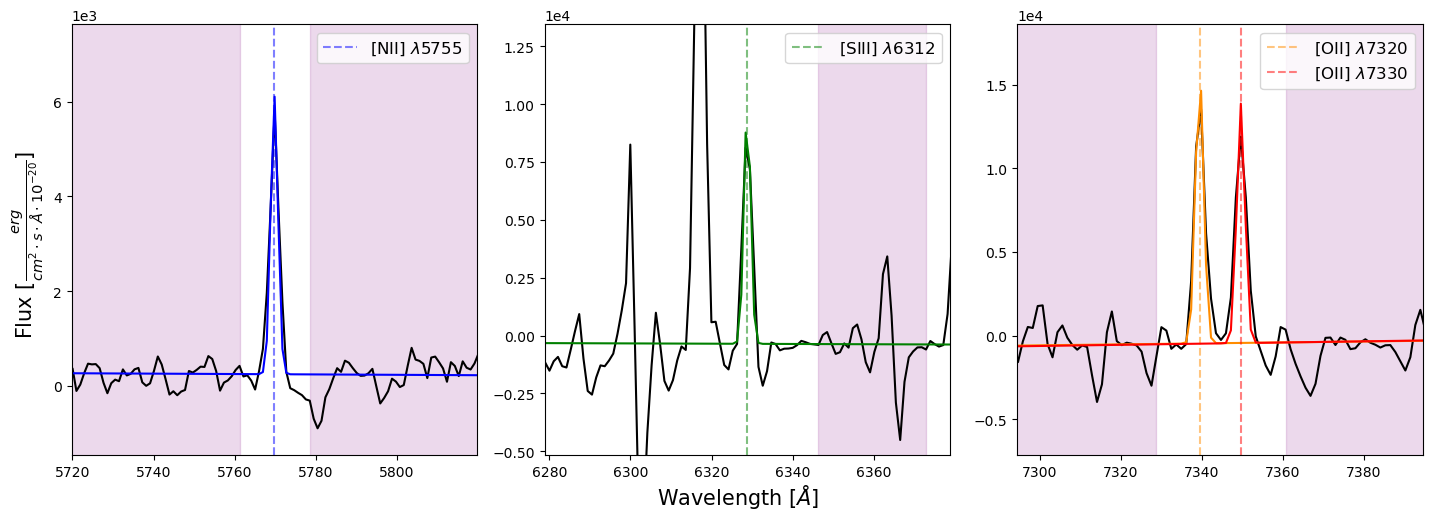

: 

In [ ]:
i = 144

wave_surr = 50
flux_bottom = -0.5
flux_top = 1.3

fig, (ax1, ax2, ax3)  = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(14)

### [NII]5755
ax1.plot(lam, fluxin[i], c='k')
lp, C = fit5755[i][4], fit5755[i][3]
ax1.plot(lam, gaussian(lam, fit5755[i][0], fit5755[i][1], fit5755[i][2]), c='blue')
ax1.axvline(fit5755[i][1], linestyle='--', c='blue', alpha=0.5, label=r'[NII] $\lambda$5755')
ax1.set_xlim(fit5755[i][1] - wave_surr , fit5755[i][1] + wave_surr)
ax1.set_ylim(flux_bottom* fit5755[i][0]*0.5, flux_top*fit5755[i][0])
ax1.fill_between(lam[np.where(lam > fit5755[i][1] - 175)[0][0]:np.where(lam > fit5755[i][1] - 8)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax1.fill_between(lam[np.where(lam > fit5755[i][1] + 180)[0][0]:np.where(lam > fit5755[i][1] + 400)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax1.fill_between(lam[np.where(lam > fit5755[i][1] + 8)[0][0]:np.where(lam > fit5755[i][1] + 100)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax1.legend(loc='upper right', fontsize=12)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

### [SIII]6312
ax2.plot(lam, fluxin[i], c='k')
lp, C = fit6312[i][4], fit6312[i][3]
ax2.plot(lam, gaussian(lam, fit6312[i][0], fit6312[i][1], fit6312[i][2]), c='green')
ax2.axvline(fit6312[i][1], linestyle='--', c='green', alpha=0.5, label=r'[SIII] $\lambda$6312')
ax2.set_xlim(fit6312[i][1] - wave_surr , fit6312[i][1] + wave_surr)
ax2.set_ylim(flux_bottom* fit6312[i][0], flux_top*fit6312[i][0])
ax2.fill_between(lam[np.where(lam > fit6312[i][1] - 200)[0][0]:np.where(lam > fit6312[i][1] - 70)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax2.fill_between(lam[np.where(lam > fit6312[i][1] + 63)[0][0]:np.where(lam > fit6312[i][1] + 120)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax2.fill_between(lam[np.where(lam > fit6312[i][1] + 17)[0][0]:np.where(lam > fit6312[i][1] + 45)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax2.legend(loc='upper right', fontsize=12)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

### [OII]7320, 7330
ax3.plot(lam, fluxin[i], c='k')
lp, C = fit7319[i][4], fit7319[i][3]
ax3.plot(lam, gaussian(lam, fit7319[i][0], fit7319[i][1], fit7319[i][2]), c='darkorange')#, label='[OII]7320 Fit')
ax3.axvline(fit7319[i][1], linestyle='--', c='darkorange', alpha=0.5, label=r'[OII] $\lambda$7320')
ax3.set_xlim(np.mean([fit7319[i][1], fit7330[i][1]]) - wave_surr , np.mean([fit7319[i][1], fit7330[i][1]]) + wave_surr)
ax3.set_ylim(flux_bottom* fit7330[i][0], flux_top*fit7330[i][0])
ax3.fill_between(lam[np.where(lam > fit7319[i][1] - 150)[0][0]:np.where(lam > fit7319[i][1] - 10)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
ax3.fill_between(lam[np.where(lam > fit7319[i][1] + 20)[0][0]:np.where(lam > fit7319[i][1] + 150)[0][0]],-10**6, 10**10, color='purple', alpha = 0.15)
lp, C = fit7330[i][4], fit7330[i][3]
ax3.plot(lam, gaussian(lam, fit7330[i][0], fit7330[i][1], fit7330[i][2]), c='red')#, label='[OII]7330 Fit')
ax3.axvline(fit7330[i][1], linestyle='--', c='red', alpha=0.5, label=r'[OII] $\lambda$7330')

ax3.legend(loc='upper right', fontsize=12)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig.text(0.5, -0.02, r'Wavelength [$\AA$]', ha='center', fontsize=15)
fig.text(-0.02, 0.5, r'Flux [$\frac{erg}{cm^{2} \cdot s \cdot \AA \cdot 10^{-20}}$]', va='center', rotation='vertical', fontsize=15)
plt.tight_layout()
plt.show()

fig.savefig("/home/habjan/SITELLE/sitelle_metallicities/figures/auroral_lines.png", bbox_inches="tight")

# Physical Quantity plots

### Plotting styles

In [8]:
plt.style.use('seaborn')

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L"]
})

### Import strong line table

In [9]:
infile = open(products_data_path + f'/strong_line_MUSE+SITELLE.fits','rb')
strong_data = Table.read(infile)

galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}

### Function to find Spearman rank correlation coefficient and MC uncertainty

In [10]:
def spear_func(in_x, in_y, in_x_err, in_y_err):
    spear = spearmanr(in_x, in_y)[0]
    spear_err = []
    for mc in range(10**3):
        try:
            spear_err.append(spearmanr(np.random.normal(in_x, in_x_err), np.random.normal(in_y, in_y_err))[0])
        except:
            continue
    return spear, np.nanstd(spear_err)

### Function to find WLS and MC uncertainty

In [11]:
def WLS_func(in_x, in_y, in_x_err, in_y_err):

    weights = 1.0 / in_y_err**2
    X = sm.add_constant(in_x)
    model = sm.WLS(in_y, X, weights=weights)
    results = model.fit()
    WLS_coef, WLS_slope = results.params[0], results.params[1]
    mc_vals = np.array([sm.WLS(np.random.normal(in_y, in_y_err), sm.add_constant(np.random.normal(in_x, in_x_err)), weights=weights).fit().params for mc in range(10**3)])

    return WLS_coef, WLS_slope, np.nanstd(mc_vals[:, 0]), np.nanstd(mc_vals[:, 1])

### Function for MC uncertainty

In [12]:
def quick_mc_err(quantity, quantity_err, iters):
    err_arr = np.array([np.random.normal(quantity, quantity_err) for mc in range(iters)])
    return np.nanstd(err_arr)

### Te-Te relationships

In [13]:
def rv23_nii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 1.35 * temp - 0.24
    return out_temp

def rv23_oii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 0.67 * temp - 0.022
    return out_temp

def rv23_oii_nii(in_temp):
    temp = in_temp / 10**4
    out_temp = 0.47 * temp + 0.36
    return out_temp

def delgado_oii_nii(in_temp):
    return 0.62 * in_temp + 2660

def chaos_nii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 1.46 * temp - 0.41
    return out_temp

def z21_nii_siii(in_temp):
    return 1.4 * in_temp - 3700

def z21_oii_siii(in_temp):
    return 0.67 * in_temp + 2200

def z21_oii_nii(in_temp):
    return 0.46 * in_temp + 4400

### Figure 5: Te-Te plot

NGC0628 9 OII_TEMP NII_TEMP
NGC2835 24 OII_TEMP NII_TEMP
NGC3351 0 OII_TEMP NII_TEMP
NGC4535 2 OII_TEMP NII_TEMP
NGC3627 0 OII_TEMP NII_TEMP
OII_TEMP NII_TEMP 0.6245640549732947 0.15424123801982603 0.056558637750425265 0.052419520382517584 35
NGC0628 5 OII_TEMP SIII_TEMP
NGC2835 11 OII_TEMP SIII_TEMP
NGC3351 0 OII_TEMP SIII_TEMP
NGC4535 2 OII_TEMP SIII_TEMP
NGC3627 0 OII_TEMP SIII_TEMP
OII_TEMP SIII_TEMP 0.6650261880169296 0.06823280223749473 0.08884763214567816 0.07847601009385118 18
NGC0628 6 NII_TEMP SIII_TEMP
NGC2835 12 NII_TEMP SIII_TEMP
NGC3351 0 NII_TEMP SIII_TEMP
NGC4535 3 NII_TEMP SIII_TEMP
NGC3627 0 NII_TEMP SIII_TEMP


NII_TEMP SIII_TEMP 0.0286621563873376 0.9177711245593132 0.059172252829560956 0.0761734521577886 21


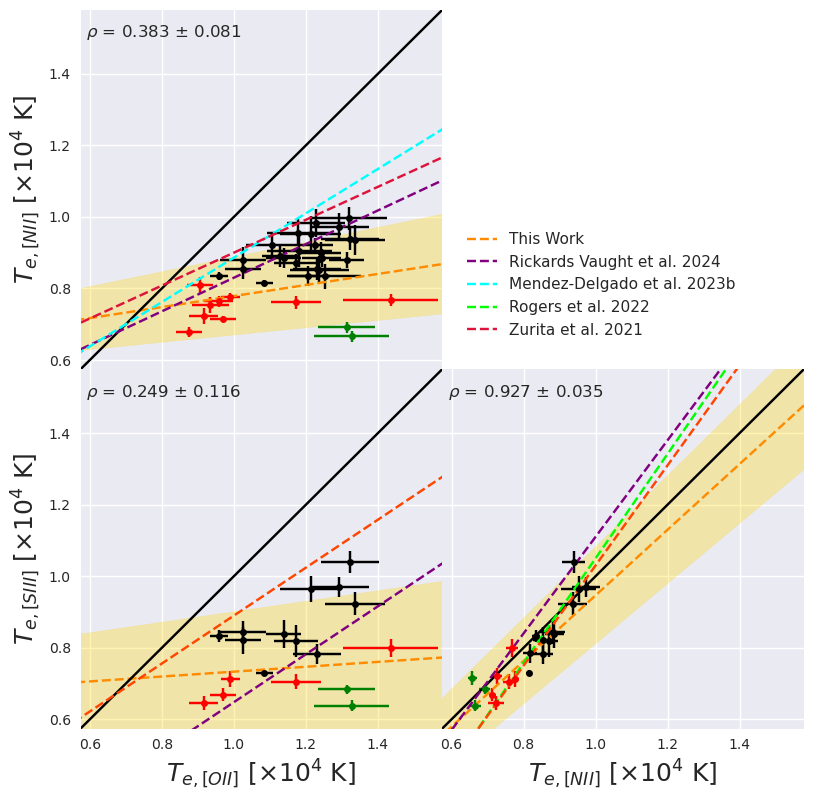

In [14]:
fig = plt.figure(figsize=(14, 14))

pq_list = ['OII_TEMP', 'NII_TEMP', 'SIII_TEMP']#, 'OIII_TEMP_MD23', 'OIII_TEMP_B12']#, 'SII_DEN_NII', 'SII_DEN_SIII']
pq_labels = [r'$T_{e, [O II]}$ [$\times 10^{4}$ K]', r'$T_{e, [N II]}$ [$\times 10^{4}$ K]', r'$T_{e, [S III]}$ [$\times 10^{4}$ K]'] 
            #r'$T_{0}(O^{2+})$ [$\times 10^{4}$ K]', r'$T_{e}$ [OIII] [$\times 10^{4}$ K]']

colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
galdic = {1:'NGC4254', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628', 6:'NGC3627'}

snr = 0.9
axes = []
mc_count = 0
label_size = 18

s_line = np.linspace(-10, 10**5, 100)

fit_plot = []

for i in range(len(pq_list)):
    lim_data = []
    for j in range(len(pq_list)):
        if j - i < 0:
            if len(axes) == 0:
                axes.append(plt.subplot2grid((len(pq_list), len(pq_list)), (i, j)))
            else:
                axes.append(plt.subplot2grid((len(pq_list), len(pq_list)), (i, j) , sharex=axes[j], sharey=axes[j]))

            if i == len(pq_list) - 1:
                axes[-1].set_xlabel(pq_labels[j], fontsize=label_size)
            if j == 0:
                axes[-1].set_ylabel(pq_labels[i], fontsize=label_size)

            if j != 0:
                axes[-1].tick_params('y', labelleft=False)
            if i != len(pq_list) - 1:
                axes[-1].tick_params('x', labelbottom=False)

            plot_data_x, plot_data_x_err = [], []
            plot_data_y, plot_data_y_err = [], []
            
            for k in range(1, len(table_dic)+1):
                plot_ind = np.where(~np.isnan(np.array(table_dic[k][pq_list[j]] + table_dic[k][pq_list[j]])) 
                                    & (table_dic[k][pq_list[i]] / table_dic[k][pq_list[i]+'_ERR'] > snr) 
                                    & (table_dic[k][pq_list[j]] / table_dic[k][pq_list[j]+'_ERR']  > snr)
                                    & (np.array(table_dic[k]['OII3727_FLUX_CORR']) > 10**6))[0]
                gal_name = table_dic[k]['gal_name'][0]
                print(gal_name, len(plot_ind), pq_list[j], pq_list[i])

                lim_data.append(np.array(table_dic[k][pq_list[i]][plot_ind]))
                lim_data.append(np.array(table_dic[k][pq_list[j]][plot_ind]))

                axes[-1].errorbar(table_dic[k][pq_list[j]][plot_ind] / 10**4, table_dic[k][pq_list[i]][plot_ind] / 10**4,
                            xerr=table_dic[k][pq_list[j]+'_ERR'][plot_ind] / 10**4, yerr=table_dic[k][pq_list[i]+'_ERR'][plot_ind] / 10**4,
                            c=colordic[k], fmt="o", markersize=5, capsize=1.5, alpha=1)

               # axes[-1].errorbar(table_dic[k][pq_list[j]][plot_ind] / 10**4, table_dic[k][pq_list[i]][plot_ind] / 10**4,
                #            #xerr=table_dic[k][pq_list[j]+'_ERR'][plot_ind] / 10**4, yerr=table_dic[k][pq_list[i]+'_ERR'][plot_ind] / 10**4,
                 #           c=colordic[k], fmt=".", markersize=8, capsize=0.5, alpha=1)
                
                div_f = 10**4
                plot_data_x = np.concatenate([plot_data_x, np.array(table_dic[k][pq_list[j]][plot_ind] / div_f)])
                plot_data_x_err = np.concatenate([plot_data_x_err, np.array(table_dic[k][pq_list[j]+'_ERR'][plot_ind] / div_f)])
                plot_data_y = np.concatenate([plot_data_y, np.array(table_dic[k][pq_list[i]][plot_ind] / div_f)])
                plot_data_y_err = np.concatenate([plot_data_y_err, np.array(table_dic[k][pq_list[i]+'_ERR'][plot_ind] / div_f)])
            
            spear, spear_err = spear_func(plot_data_x, plot_data_y, plot_data_x_err, plot_data_y_err)

            fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(plot_data_x, plot_data_y, plot_data_x_err, plot_data_y_err)

            print(pq_list[j], pq_list[i], fit_coef, fit_slope, fit_coef_err, fit_slope_err, len(plot_data_x))

            axes[-1].plot(s_line, fit_coef + fit_slope*s_line, 
                          c='darkorange', linestyle='--')#, 
                          #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
            axes[-1].fill_between(s_line, 
                                  (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*s_line, 
                                  (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*s_line,
                                  color='gold', alpha=0.3)
            
            axes[-1].text(0.59, 1.502, 
                          r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}',
                          fontsize = 12)
            
            axes[-1].plot(np.linspace(-1, 10**11, 10), np.linspace(-1, 10**11, 10), c='k', alpha=1)
            
            #Te-Te relations from other papers
            
            if pq_list[i] == 'SIII_TEMP' and pq_list[j] == 'NII_TEMP':
                
                plt.plot(s_line / 10**4, rv23_nii_siii(s_line), c='purple', linestyle='--')
                plt.plot(s_line / 10**4, chaos_nii_siii(s_line), c='lime', linestyle='--')
                plt.plot(s_line  / 10**4, z21_nii_siii(s_line)  / 10**4, c='orangered', linestyle='--')
            
            if pq_list[i] == 'SIII_TEMP' and pq_list[j] == 'OII_TEMP':
                
                plt.plot(s_line  / 10**4, rv23_oii_siii(s_line), c='purple', linestyle='--')
                plt.plot(s_line  / 10**4, z21_oii_siii(s_line)  / 10**4, c='orangered', linestyle='--')
                
            if pq_list[i] == 'NII_TEMP' and pq_list[j] == 'OII_TEMP':
                
                plt.plot(s_line / 10**4, rv23_oii_nii(s_line), c='purple', linestyle='--')
                plt.plot(s_line  / 10**4, delgado_oii_nii(s_line)  / 10**4, c='cyan', linestyle='--')
                plt.plot(s_line  / 10**4, z21_oii_nii(s_line)  / 10**4, c='crimson', linestyle='--')

    if i != 0:
        l_bound = np.quantile(np.concatenate(lim_data) / 10**4, 0)
        h_bound = np.quantile(np.concatenate(lim_data) / 10**4, 1)
        up_val = 1.1
        down_val = 0.9
        axes[-1].set_ylim(l_bound*down_val, h_bound*up_val)
        axes[-1].set_xlim(l_bound*down_val, h_bound*up_val)
        #axes[-1].set_ylim(0.5, 2.35)
        #axes[-1].set_xlim(0.5, 2.35)
        #axes[-1].set_xscale('log')
        #axes[-1].set_yscale('log')

f_line = np.linspace(-10, -1, 10)
plt.plot(f_line, f_line, c='darkorange', linestyle='--', label='This Work')
plt.plot(f_line, f_line, c='purple', linestyle='--', label='Rickards Vaught et al. 2024')
plt.plot(f_line, f_line, c='cyan', linestyle='--', label='Mendez-Delgado et al. 2023b')
plt.plot(f_line, f_line, c='lime', linestyle='--', label='Rogers et al. 2022')
plt.plot(f_line, f_line, c='crimson', linestyle='--', label='Zurita et al. 2021')

plt.legend(bbox_to_anchor=(0.85, 1.05), fontsize = 11)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig("/home/habjan/SITELLE/sitelle_metallicities/figures/temp_corner.png", bbox_inches="tight")

### Figure 6: density-density plot

7
16
0
2
0


Text(0.5, 0, '$n_{e, [OII]7325+/3727+}$ [$log(cm^{-3})$]')

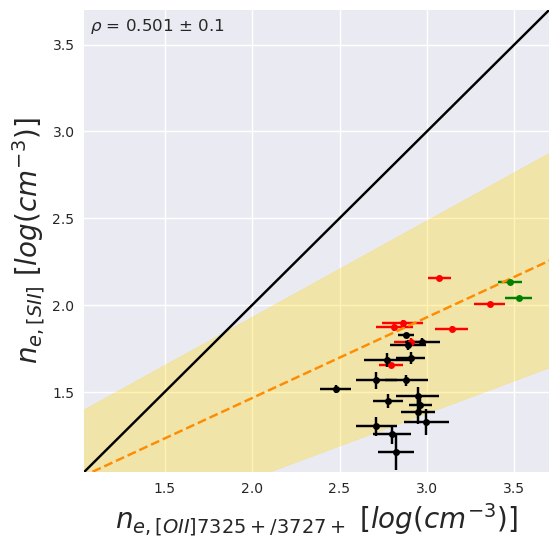

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(6,6), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

mark_s = 5
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII]) - n([SII])

oii_log = np.log10(strong_data['OII_DEN'])
oii_err = 1/np.log(10) * ((strong_data['OII_DEN_ERR']) / (strong_data['OII_DEN']))

sii_log = np.log10(strong_data['SII_DEN'])
sii_err = 1/np.log(10) * ((strong_data['SII_DEN_ERR']) / (strong_data['SII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) 
                        & (1 / (np.log(10) * oii_err) > snr) 
                        & (1 / (np.log(10) * sii_err) > snr)
                        & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    axs.errorbar(oii_log[plot_ind], sii_log[plot_ind],
                 xerr = oii_err[plot_ind],
                 yerr= sii_err[plot_ind], 
                 c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)
    
    print(len(plot_ind))

plot_ind_1 = np.where((1 / (np.log(10) * oii_err) > snr) & (1 / (np.log(10) * sii_err) > snr))[0]

x, y = oii_log[plot_ind_1], sii_log[plot_ind_1]
x_err = oii_err[plot_ind_1]
y_err = sii_err[plot_ind_1]

axs.set_xlim(np.nanmin(np.concatenate([x, y]))*0.9, np.nanmax(np.concatenate([x, y]))*1.05)
axs.set_ylim(np.nanmin(np.concatenate([x, y]))*0.9, np.nanmax(np.concatenate([x, y]))*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.3)

axs.text(1.07, 3.58, 
         r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}',
         fontsize = 12)

axs.plot(np.linspace(-2, 5, 100), np.linspace(-2, 5, 100), c='k')

axs.set_ylabel(r'$n_{e, [SII]}$ [$log(cm^{-3})$]', fontsize = 20)
#axs.set_xlabel(r'log(n([OII]) - n([SII]))')
axs.set_xlabel(r'$n_{e, [OII]7325+/3727+}$ [$log(cm^{-3})$]', fontsize = 20)
#axs.legend(loc='upper left')

### Figure 7: O+ abundances

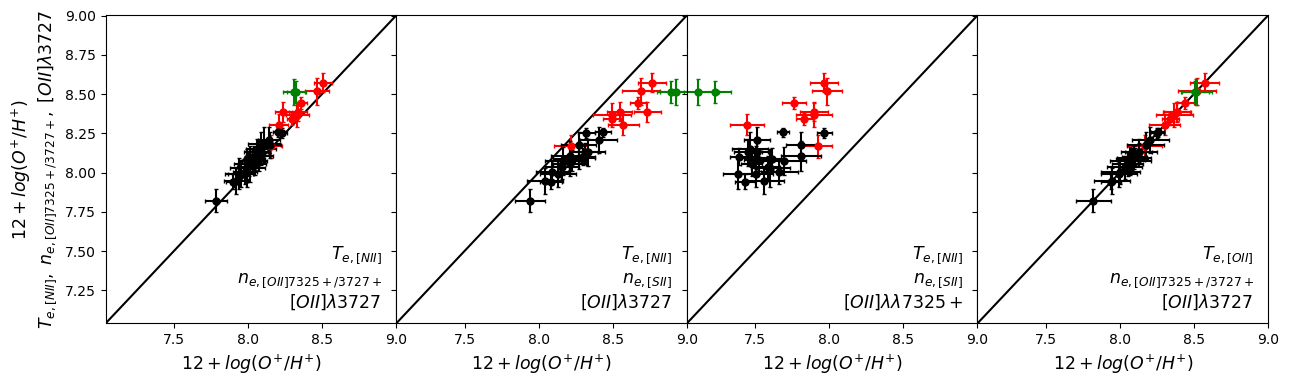

In [16]:
plt.style.use('default')

seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['O2_NII_3727_SII', 'O2_NII_7325_SII', 'O2_OII_3727_OII', 'O2_NII_7325_OII'])

plot_type = 'paper'

if plot_type == 'paper':
    pq_labels = [r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$ $n_{e, [OII]7325+/3727+},$ $[OII]\lambda3727$', 
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda\lambda7325+$', 
             r'$T_{e, [OII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda\lambda7325+$',]
    label_size = 12.5

elif plot_type == 'presentation':
    
    pq_labels = [r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+},$' + '\n' + r'$[OII]\lambda3727$', 
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda\lambda7325+$', 
             r'$T_{e, [OII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda\lambda7325+$',]
    label_size = 20

plt.figure(figsize=(15, 20))
axes = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,4,j+1))
    else:
        axes.append(plt.subplot(5,4,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%4 == 1 or j%4 == 2 or j%4 == 3:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(r'$12 + log\left(O^{+}/H^{+}\right)$', fontsize = label_size)
    axes[-1].text(0.95, 0.05, pq_labels[j+1], color='k', ha="right", transform=axes[j].transAxes, 
                  fontweight = 'bold', fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(6, 10, 10), np.linspace(6, 10, 10), c='k', alpha=1)

    lim_list = []

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) 
                             & (strong_data['O2_NII_3727_OII']/strong_data['O2_NII_3727_OII_ERR'] > snr) 
                             & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr)
                             & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(12+np.log10(strong_data[labels[j]][plot_bool]), 12+np.log10(strong_data['O2_NII_3727_OII'][plot_bool]),
                         xerr=1/np.log(10) * (strong_data[labels[j]+'_ERR'][plot_bool] / strong_data[labels[j]][plot_bool]),
                         yerr= 1/np.log(10) * (strong_data['O2_NII_3727_OII_ERR'][plot_bool] / strong_data['O2_NII_3727_OII'][plot_bool]), 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(12+np.log10(strong_data[labels[j]][plot_bool]))) 
        lim_list.append(np.array(12+np.log10(strong_data['O2_NII_3727_OII'][plot_bool])))  

    lim_list = np.concatenate(lim_list)

    axes[-1].set_ylim(np.nanquantile(lim_list, 0)*0.9, np.nanquantile(lim_list, 1)*1.05)
    axes[-1].set_xlim(np.nanquantile(lim_list, 0)*0.9, np.nanquantile(lim_list, 1)*1.05)

    #axes[-1].text(0.475, 10, pq_labels[j+1])

    #axes[j].legend(fontsize=9)

plt.subplots_adjust(wspace=0,hspace=0)

### Figure 8: O2+ abundances

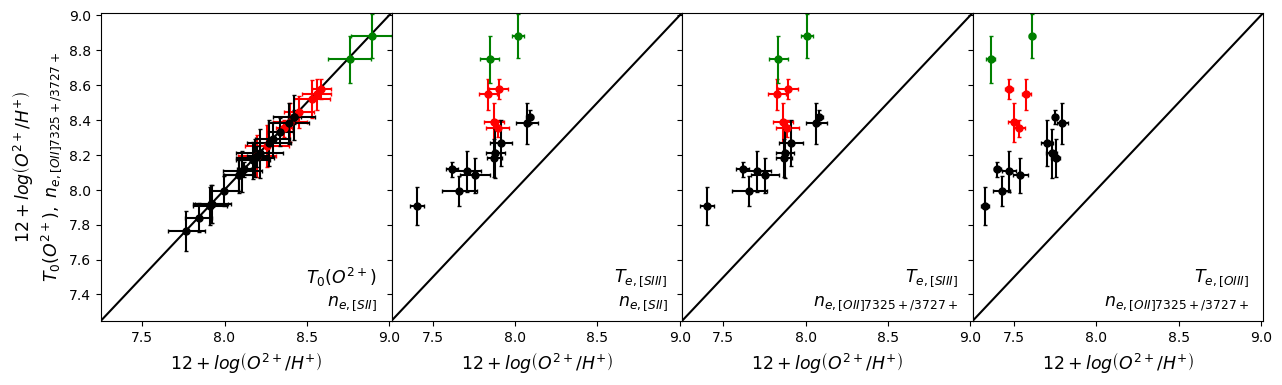

In [17]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['O3_T0_SII', 'O3_SIII_SII', 'O3_SIII_OII', 'O3_OIII_OII'])

plot_type = 'paper'

if plot_type == 'paper':
    
    pq_labels = [
        r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{0}(O^{2+}),$ $n_{e, [OII]7325+/3727+}$', 
        r'$T_{0}(O^{2+})$' + '\n' + r'$n_{e, [SII]}$',
        r'$T_{e, [SIII]}$' + '\n' + r'$n_{e, [SII]}$',
        r'$T_{e, [SIII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$', 
        r'$T_{e, [OIII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$']
    label_size = 12.5

elif plot_type == 'presentation':
    
    pq_labels = [
        r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{0}(O^{2+})$' + '\n' + r'$n_{e, [OII]7325+/3727+}$', 
        r'$T_{0}(O^{2+}),$' + '\n' + r'$n_{e, [SII]}$',
        r'$T_{e, [SIII]},$' + '\n' + r'$n_{e, [SII]}$',
        r'$T_{e, [SIII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+}$', 
        r'$T_{e, [OIII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+}$']
    label_size = 20

plt.figure(figsize=(15, 20))
axes = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,4,j+1))
    else:
        axes.append(plt.subplot(5,4,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%4 == 1 or j%4 == 2 or j%4 == 3:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(r'$12 + log\left(O^{2+}/H^{+}\right)$', fontsize = label_size)
    axes[-1].text(0.95, 0.05, pq_labels[j+1], color='k', ha="right", transform=axes[j].transAxes, 
                  fontweight = 'bold', fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(6, 10, 10), np.linspace(6, 10, 10), c='k', alpha=1)

    lim_list = []

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) 
                             & (strong_data['O3_T0_OII']/strong_data['O3_T0_OII_ERR'] > snr) 
                             & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr)
                             & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(12+np.log10(strong_data[labels[j]][plot_bool]), 12+np.log10(strong_data['O3_T0_OII'][plot_bool]),
                         xerr=1/np.log(10) * (strong_data[labels[j]+'_ERR'][plot_bool] / strong_data[labels[j]][plot_bool]),
                         yerr= 1/np.log(10) * (strong_data['O3_T0_OII_ERR'][plot_bool] / strong_data['O3_T0_OII'][plot_bool]), 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(12+np.log10(strong_data[labels[j]][plot_bool]))) 
        lim_list.append(np.array(12+np.log10(strong_data['O3_T0_OII'][plot_bool])))  

    lim_list = np.concatenate(lim_list)

    axes[-1].set_ylim(np.nanquantile(lim_list, 0)*0.99, np.nanquantile(lim_list, 1)*1.015)
    axes[-1].set_xlim(np.nanquantile(lim_list, 0)*0.99, np.nanquantile(lim_list, 1)*1.015)

    #axes[-1].text(0.475, 10, pq_labels[j+1])

    #axes[j].legend(fontsize=9)

plt.subplots_adjust(wspace=0,hspace=0)

### Figure 9: total metallicities

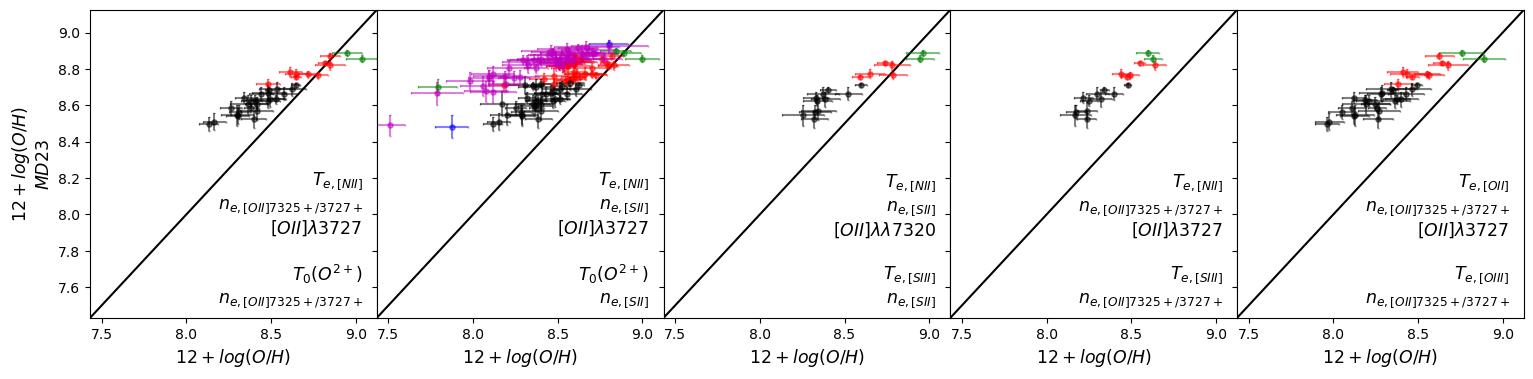

In [18]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['OH_T0_OII_NII_OII_3727', 'OH_T0_SII_NII_SII_3727', 'OH_SIII_SII_NII_SII_7325', 
                   'OH_SIII_OII_NII_OII_3727', 'OH_T0_OII_OII_OII_3727'])

pq_labels = [r'$12+log(O/H)$' + '\n' + r'$MD23$', 
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$' + '\n' + '\n' + r'$T_{0}(O^{2+})$' + '\n' + r'$n_{e, [OII]7325+/3727+}$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda3727$' + '\n' + '\n' + r'$T_{0}(O^{2+})$' + '\n' + r'$n_{e, [SII]}$',
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [SII]}$' + '\n' + r'$[OII]\lambda\lambda7320$' + '\n' + '\n' + r'$T_{e, [SIII]}$' + '\n' + r'$n_{e, [SII]}$', 
             r'$T_{e, [NII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$' + '\n' + '\n' + r'$T_{e, [SIII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$',
             r'$T_{e, [OII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$' + '\n' + r'$[OII]\lambda3727$' + '\n' + '\n' + r'$T_{e, [OIII]}$' + '\n' + r'$n_{e, [OII]7325+/3727+}$',]

label_size = 12.5

plt.figure(figsize=(18.5, 20))
axes = []
lim_list = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,5,j+1))
    else:
        axes.append(plt.subplot(5,5,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%5 == 1 or j%5 == 2 or j%5 == 3 or j%5 == 4:
        axes[j].tick_params('y', labelleft=False)
    
    #axes[-1].set_xlabel(pq_labels[j+1], fontsize = label_size)
    axes[-1].set_xlabel(r'$12+log(O/H)$', fontsize = label_size)
    axes[-1].text(0.95, 0.05, pq_labels[j+1], color='k', ha="right", transform=axes[j].transAxes, 
                  fontweight = 'bold', fontsize = label_size)
    if j == 0:
        #axes[-1].text(0.9, 0.1, pq_labels[0], color='red', transform=axes[j].transAxes)
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(-10, 20, 10), np.linspace(-10, 20, 10), c='k', alpha=1)

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) 
                             & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr)
                             & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]
        a_val = 0.5
        mark_s = 7.5
        cap_s = 1
        axes[j].errorbar(strong_data[labels[j]][plot_bool], strong_data['met_md23'][plot_bool],
                         xerr=strong_data[labels[j]+'_ERR'][plot_bool],
                         yerr= strong_data['met_md23_err'][plot_bool], 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        
        lim_list.append(np.array(strong_data[labels[j]][plot_bool])) 
        lim_list.append(np.array(strong_data['met_md23'][plot_bool]))  

lim_list_1 = np.concatenate(lim_list)

axes[-1].set_ylim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)
axes[-1].set_xlim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)

plt.subplots_adjust(wspace=0,hspace=0)

### Code to find the Strong Line method that agrees best with a metallicity

In [23]:
Z_comp, Z_comp_err = 'met_md23', 'met_md23_err'
#Z_comp, Z_comp_err = 'OH_T0_OII_NII_OII_3727', 'OH_T0_OII_NII_OII_3727_ERR'
#Z_comp, Z_comp_err = 'OH_SIII_SII_NII_SII_7325', 'OH_SIII_SII_NII_SII_7325_ERR'
#Z_comp, Z_comp_err = 'OH_SIII_OII_NII_OII_3727', 'OH_SIII_OII_NII_OII_3727_ERR'

Z_arr = np.array(strong_data[Z_comp]) #10**(np.array(strong_data[Z_comp])-12)
Z_arr_err = np.array(strong_data[Z_comp_err]) #* np.log(10) * Z_arr

strong_list = np.array(['met_scal', 'met_rcal', 'met_rs2Dcal', 'met_kk04', 'met_m91', 'met_p05', 'met_d02', 
                        'met_m13_o3n2', 'met_m13_n2', 'met_d16'])
strong_list_err = np.array(['met_scal_err', 'met_rcal_err', 'met_rs2Dcal_err','met_kk04_err', 'met_m91_err', 
                            'met_p05_err', 'met_d02_err', 'met_m13_o3n2_err', 'met_m13_n2_err', 'met_d16_err'])

len_arr = np.zeros(len(strong_list))

chi2 = np.zeros(len(strong_list))
chi2_err = np.zeros(len(strong_list))

chi2 = np.zeros(len(strong_list))
chi2_err = np.zeros(len(strong_list))

spearman = np.zeros(len(strong_list))
spearman_err = np.zeros(len(strong_list))

fit_coef_arr, fit_slope_arr, fit_coef_arr_err, fit_slope_arr_err = np.zeros(len(strong_list)), np.zeros(len(strong_list)), np.zeros(len(strong_list)), np.zeros(len(strong_list))

snr = 5

for i in range(len(strong_list)):
    strong_arr = np.array(strong_data[strong_list[i]]) #10**(np.array(strong_data[strong_list[i]])-12)
    strong_arr_err = np.array(strong_data[strong_list_err[i]]) #* np.log(10) * strong_arr

    comp_ind = np.where(~np.isnan(strong_arr) 
                        & ~np.isnan(Z_arr) 
                        & (1 / (np.log(10)*strong_arr_err) > snr) 
                        & (1 / (np.log(10)*Z_arr_err) > snr)
                        & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    len_arr[i] = len(comp_ind)

    chi2[i] = np.sum(((strong_arr[comp_ind] - Z_arr[comp_ind]) / strong_arr_err[comp_ind]) ** 2) / len_arr[i]

    ### Error propagation 
    mc_err = np.full(10**3, np.nan)
    for mc in range(len(mc_err)):
        
        mc_err[mc] = np.sqrt(np.nansum(((((np.random.normal(strong_arr[comp_ind], strong_arr_err[comp_ind]) - np.random.normal(Z_arr[comp_ind], Z_arr_err[comp_ind])) / strong_arr_err[comp_ind]) ** 2) - chi2[i])**2) / (len_arr[i] - 1))
        
    chi2_err[i] = np.nanstd(mc_err)
    #chi2_err[i] = np.sqrt(np.nansum(((((strong_arr[comp_ind] - Z_arr[comp_ind]) / strong_arr_err[comp_ind]) ** 2) - chi2[i])**2) / (len_arr[i] - 1))

    spearman[i], spearman_err[i] = spear_func(strong_arr[comp_ind], Z_arr[comp_ind], strong_arr_err[comp_ind], Z_arr_err[comp_ind])

    fit_coef_arr[i], fit_slope_arr[i], fit_coef_arr_err[i], fit_slope_arr_err[i] = WLS_func(strong_arr[comp_ind], Z_arr[comp_ind], strong_arr_err[comp_ind], Z_arr_err[comp_ind])

best_strong_ind = np.where(np.min(chi2) == chi2)[0]
best_strong = strong_list[best_strong_ind][0]

best_spear_ind = np.where(np.max(spearman) == spearman)[0]
best_spear = strong_list[best_spear_ind][0]

best_slope_ind = np.where(np.min(abs(fit_slope_arr - 1)) == abs(fit_slope_arr - 1))[0]
best_slope = strong_list[best_slope_ind][0]

print(best_strong, len_arr)
print(best_spear)
print(best_slope)

for i in range(len(strong_list)):
    print(f'{strong_list[i]} with an average of {np.round(chi2[i], 4)} with an uncertainty of {np.round(chi2_err[i], 4)}')
    print(f'Spearnman {np.round(spearman[i], 4)} with an uncertainty of {np.round(spearman_err[i], 4)}')
    print(f'Slope of {fit_slope_arr[i]} with uncertainty of {fit_slope_arr_err[i]}')
    print(' ')

met_p05 [114. 121. 121. 121. 121. 121. 121. 121. 121. 121.]
met_d16
met_m91
met_scal with an average of 142097.8198 with an uncertainty of 9519.7728
Spearnman 0.7713 with an uncertainty of 0.0199
Slope of 1.2767256537401126 with uncertainty of 0.04051941154952267
 
met_rcal with an average of 1482.8624 with an uncertainty of 97.6753
Spearnman 0.7421 with an uncertainty of 0.0261
Slope of 1.413521693185703 with uncertainty of 0.04184783839333443
 
met_rs2Dcal with an average of 110496.9271 with an uncertainty of 8848.2783
Spearnman 0.7417 with an uncertainty of 0.0191
Slope of 1.409413489216821 with uncertainty of 0.04177477985035013
 
met_kk04 with an average of 3551.2568 with an uncertainty of 99.0925
Spearnman 0.7338 with an uncertainty of 0.0223
Slope of 1.0630892027382428 with uncertainty of 0.03589264440664341
 
met_m91 with an average of 1435.1377 with an uncertainty of 95.3777
Spearnman 0.7321 with an uncertainty of 0.0223
Slope of 0.9660419817584027 with uncertainty of 0.029803

### Figure 10: Direct and Strong Line metallicity comparison

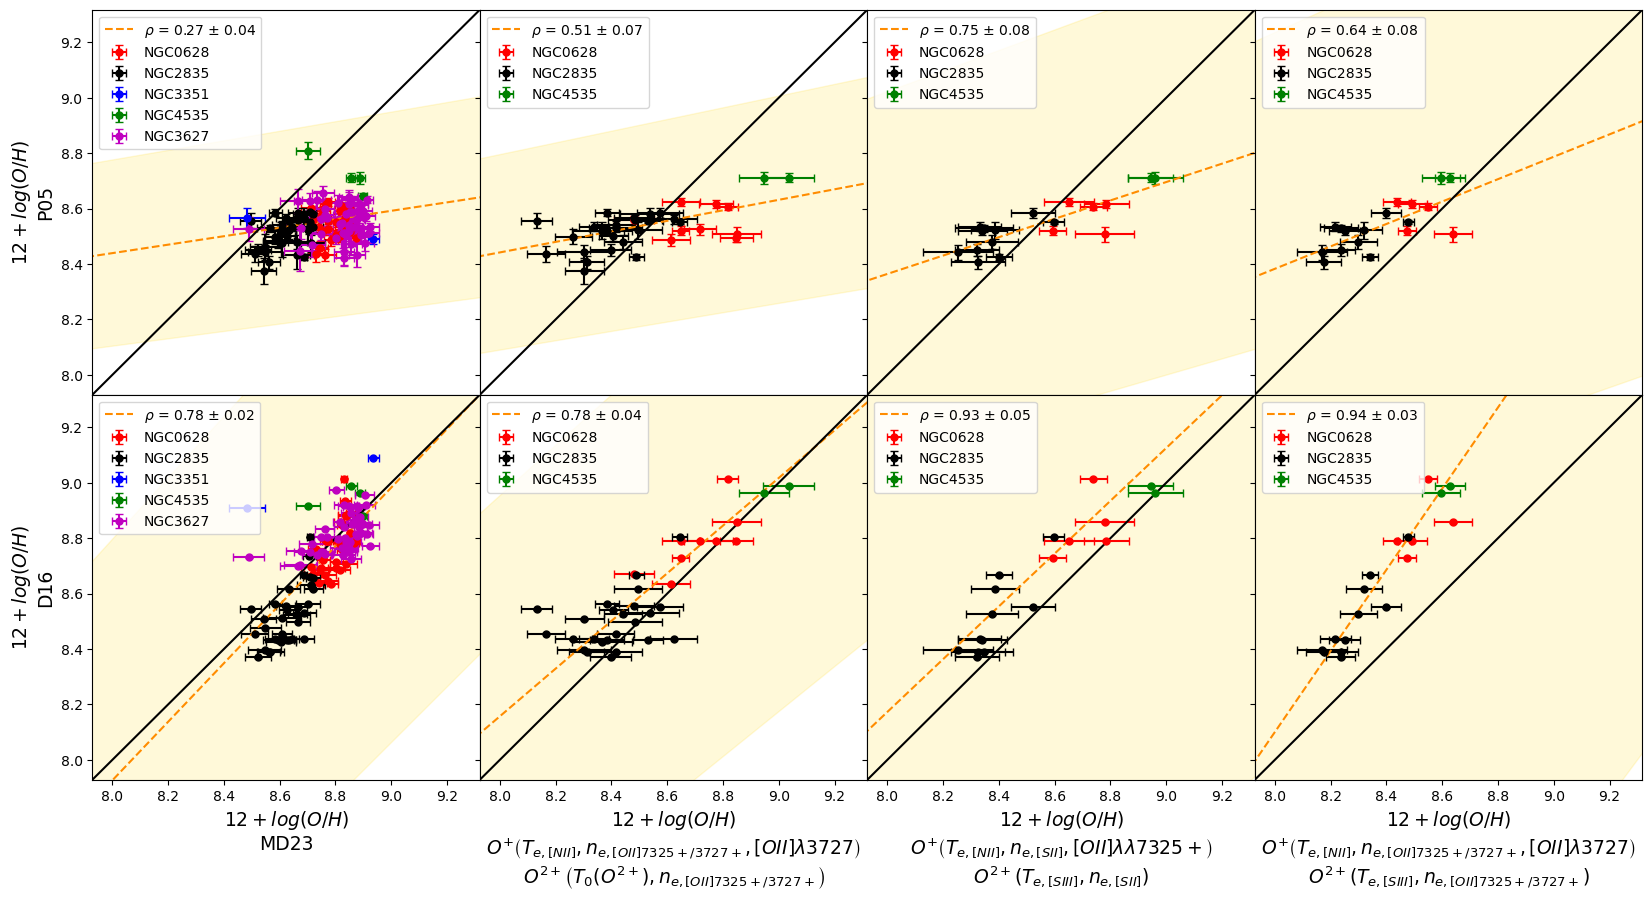

In [24]:
snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 13.5
legend_size = 10
spear_dec = 2

#met_labs = np.array(['met_scal', 'met_rcal', 'met_rs2Dcal', 'met_kk04'])
met_labs = np.array(['met_p05', 'met_d16'])

#met_label_dict = {'met_scal':'PG16-Scal', 'met_rcal':'PG16-Rcal', 'met_rs2Dcal':'PG16-RScal', 'met_kk04':'KK04'}  #'met_p05':'P05', 'met_d16':'D16', 'met_md23':'MD23'
met_label_dict = {'met_p05':'P05', 'met_d16':'D16'}  #'met_p05':'P05', 'met_d16':'D16', 'met_md23':'MD23'

fig, axs = plt.subplots(len(met_label_dict), 4, figsize=(20, 5*len(met_label_dict)), sharey=True, sharex=True)

lim_list = []

for j in range(len(met_labs)):
    
    met_in, met_in_err = met_labs[j], met_labs[j]+'_err'
    plt_lab = met_label_dict[met_labs[j]]

    ### MD23

    for k in range(2, len(galdic)+1):

        plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) 
                              & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) 
                              & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                              & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

        if len(plot_ind_1) > 0:
        
            axs[j][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data[met_in_err][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) 
                          & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                          & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    axs[j][0].set_ylabel(r'$12+log(O/H)$' + '\n' + f'{plt_lab}', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][0].set_xlabel(r'$12+log(O/H)$' + '\n' + r'MD23', fontsize = label_size)

    x, y = strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1]
    x_err = strong_data['met_md23_err'][plot_ind_1]
    y_err = strong_data[met_in_err][plot_ind_1]

    axs[j][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs.text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][0].legend(loc='upper left', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(Benchmark)
    
    bench_met = 'OH_T0_OII_NII_OII_3727'

    for k in range(2, len(galdic)+1):

        plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) 
                              & (1 / (np.log(10) * np.array(strong_data[bench_met + '_ERR'])) > snr) 
                              & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                              & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

        if len(plot_ind_2) > 0:
        
            axs[j][1].errorbar(strong_data[bench_met][plot_ind_2], strong_data[met_in][plot_ind_2],
                    xerr = strong_data[bench_met + '_ERR'][plot_ind_2],
                    yerr = strong_data[met_in_err][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data[bench_met + '_ERR'])) > snr) 
                          & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                          & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    #axs[j][1].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][1].set_xlabel(r'$12+log(O/H)$' + '\n' + r'$O^{+}$$\left(T_{e, [NII]}, n_{e, [OII]7325+/3727+}, [OII]\lambda3727 \right)$' + '\n' + r'$O^{2+}$$\left(T_{0}(O^{2+}), n_{e, [OII]7325+/3727+}\right)$', fontsize = label_size)

    x, y = strong_data[bench_met][plot_ind_2], strong_data[met_in][plot_ind_2]
    x_err = strong_data[bench_met + '_ERR'][plot_ind_2]
    y_err = strong_data[met_in_err][plot_ind_2]

    axs[j][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][1].legend(loc='upper left', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(MUSE)
    
    muse_met = 'OH_SIII_SII_NII_SII_7325'

    for k in range(2, len(galdic)+1):

        plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) 
                              & (1 / (np.log(10) * np.array(strong_data[muse_met + '_ERR'])) > snr) 
                              & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                              & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

        if len(plot_ind_3) > 0:
        
            axs[j][2].errorbar(strong_data[muse_met][plot_ind_3], strong_data[met_in][plot_ind_3],
                    xerr = strong_data[muse_met + '_ERR'][plot_ind_3],
                    yerr = strong_data[met_in_err][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data[muse_met + '_ERR'])) > snr) 
                          & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                          & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    #axs[j][2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][2].set_xlabel(r'$12+log(O/H)$' + '\n' + r'$O^{+}$$\left(T_{e, [NII]}, n_{e, [SII]}, [OII]\lambda\lambda7325+ \right)$' + '\n' + r'$O^{2+}$$\left(T_{e, [SIII]}, n_{e, [SII]}\right)$', fontsize = label_size)

    x, y = strong_data[muse_met][plot_ind_3], strong_data[met_in][plot_ind_3]
    x_err = strong_data[muse_met + '_ERR'][plot_ind_3]
    y_err = strong_data[met_in_err][plot_ind_3]

    axs[j][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][2].legend(loc='upper left', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(t^2 > 0)
    
    siii_met = 'OH_SIII_OII_NII_OII_3727'

    for k in range(2, len(galdic)+1):

        plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) 
                              & (1 / (np.log(10) * np.array(strong_data[siii_met +'_ERR'])) > snr) 
                              & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                              & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

        if len(plot_ind_4) > 0:
        
            axs[j][3].errorbar(strong_data[siii_met][plot_ind_4], strong_data[met_in][plot_ind_4],
                    xerr = strong_data[siii_met + '_ERR'][plot_ind_4],
                    yerr = strong_data[met_in_err][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

    plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data[siii_met +'_ERR'])) > snr) 
                          & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr)
                          & (np.array(strong_data['OII3727_FLUX_CORR']) > 10**6))[0]

    #axs[j][3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][3].set_xlabel(r'$12+log(O/H)$' + '\n' + r'$O^{+}$$\left(T_{e, [NII]}, n_{e, [OII]7325+/3727+}, [OII]\lambda3727 \right)$' + '\n' + r'$O^{2+}$$\left(T_{e, [SIII]}, n_{e, [OII]7325+/3727+}\right)$', fontsize = label_size)
        
    x, y = strong_data[siii_met][plot_ind_4], strong_data[met_in][plot_ind_4]
    x_err = strong_data[siii_met + '_ERR'][plot_ind_4]
    y_err = strong_data[met_in_err][plot_ind_4]

    axs[j][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][3].legend(loc='upper left', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)
    lim_arr = np.concatenate(lim_list)
    axs[j][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
    axs[j][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 11: Strong Line metallicity gradient

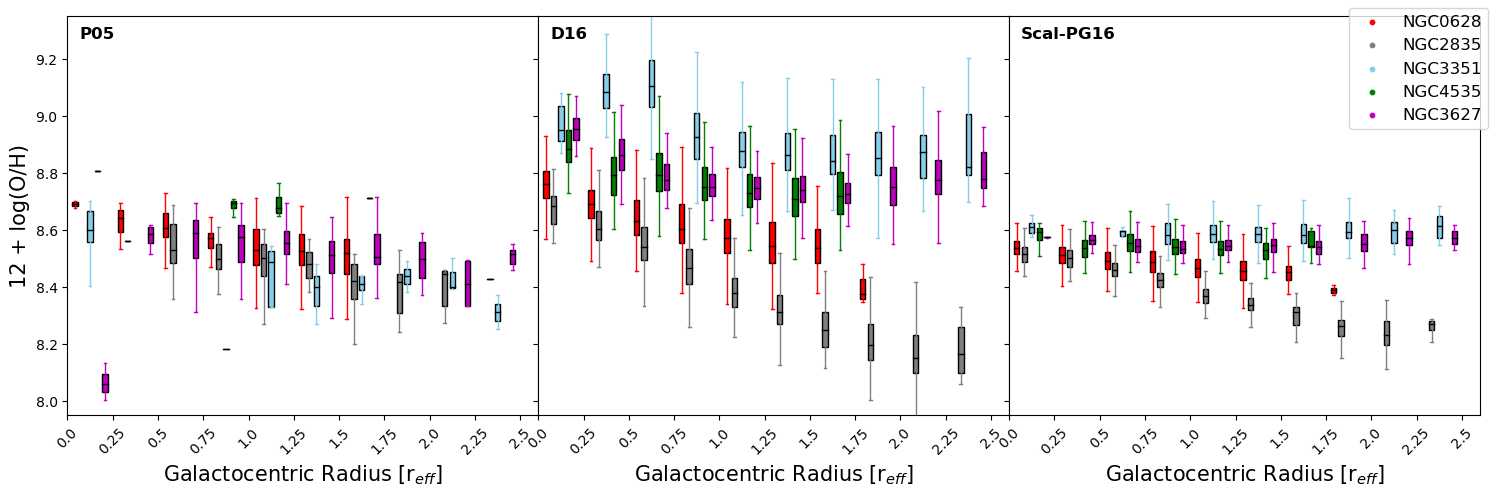

In [28]:
mets = [best_strong, 'met_d16', 'met_scal']  # e.g. ['met_p05', 'met_d16', 'met_scal']

dx = 0.25
bin_dict = {1: -(dx/6)*2, 2:-(dx/6), 3:0, 4:(dx/6), 5:(dx/6)*2}
colordic = {1: 'red', 2:'gray', 3:'skyblue', 4:'green', 5:'m'}

met_label_dict = {
    'met_scal':'Scal-PG16',
    'met_rcal':'Rcal-PG16',
    'met_rs2Dcal':'RScal-PG16',
    'met_kk04':'KK04', 
    'met_m91':'M91',
    'met_p05':'P05',
    'met_d02':'D02',
    'met_m13_o3n2':'O3N2-M13',
    'met_m13_n2':'N2-M13',
    'met_d16':'D16',
    'met_md23':'MD23'
}

def plot_one_met_panel(ax, met):
    """Make one panel on axis `ax` for a given metallicity column `met`."""
    plot_lim_arr = []

    for i in range(1, len(galdic)):
        plot_bool = strong_data['gal_name'] == table_dic[i]['gal_name'][0]

        md23_ind = np.where(
            (1 / (np.log(10) * np.array(strong_data[met+'_err'][plot_bool])) > snr) 
            & (np.abs(strong_data[met][plot_bool] / strong_data[met+'_err'][plot_bool]) < 10**10)
            #& (np.array(strong_data[plot_bool]['OII3727_FLUX_CORR']) > 10**6)
        )[0]

        x = np.array(strong_data['r_reff'][plot_bool][md23_ind])
        y = np.array(strong_data[met][plot_bool][md23_ind])

        if len(x) == 0:
            continue

        bins = np.arange(0, np.max(x) + dx, dx)
        bin_indices = np.digitize(x, bins)

        # boxplots per radial bin
        for k in range(1, len(bins)):
            bin_data = y[bin_indices == k]
            if len(bin_data) > 0:
                ax.boxplot(
                    bin_data,
                    positions=[bins[k-1] + dx/2 + bin_dict[i]],
                    boxprops=dict(edgecolor='k', alpha=1, facecolor=colordic[i]),
                    capprops=dict(color=colordic[i]),
                    flierprops=dict(
                        marker='.', markerfacecolor=colordic[i],
                        markersize=8, markeredgecolor=colordic[i]
                    ),
                    whiskerprops=dict(color=colordic[i]),
                    medianprops=dict(color='k'),
                    showfliers=False,
                    showbox=True,
                    widths=0.03,
                    patch_artist=True
                )

        # dummy scatter just to build the legend
        ax.scatter([0], [0], color=colordic[i], marker='o', s=10,
                   label=f'{galdic[i+1]}')

        plot_lim_arr = np.concatenate([plot_lim_arr, y])

    # x-ticks / limits
    rounded_bins = np.around(bins, decimals=2)
    ax.set_xticks(rounded_bins)
    ax.set_xticklabels(rounded_bins, rotation=45)

    ax.set_xlim(0, 2.6)
    ax.set_ylim(7.95, 9.35)
    ax.set_xlabel(r'Galactocentric Radius [r$_{eff}$]', fontsize=15)

    # 2. label (e.g. P05, D16, Scal-PG16) in upper-left using annotate
    ax.annotate(
        met_label_dict[met],
        xy=(0.025, 0.975), xycoords='axes fraction',
        ha='left', va='top',
        fontsize=12, fontweight='bold'
    )
    # 1. no ax.set_title() here


# -------- 3-panel figure --------
fig, axes = plt.subplots(1, len(mets), figsize=(15, 5), sharex=True, sharey=True, gridspec_kw={"wspace": 0, "hspace": 0})

if len(mets) == 1:
    axes = [axes]

for j, met in enumerate(mets):
    plot_one_met_panel(axes[j], met)

# 3. only left-most y-label
axes[0].set_ylabel(r'12 + log(O/H)', fontsize=15)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

fig.tight_layout()
plt.show()


In [29]:
strong_data

<Table length=8847>
gal_name region_ID       cen_x        ... met_md23_err  NO_t96 NO_t96_err
                          pix         ...                                
bytes32   float64       float64       ...   float64    float64  float64  
-------- --------- ------------------ ... ------------ ------- ----------
 NGC4535       0.0  253.4610147234282 ...           --      --         --
 NGC4535       1.0 324.51167040839283 ...           --      --         --
 NGC4535       2.0 394.61554678261797 ...           --      --         --
 NGC4535       3.0   440.386947989404 ...           --      --         --
 NGC4535       4.0 367.29996342612407 ...           --      --         --
 NGC4535       5.0 438.73569736133976 ...           --      --         --
 NGC4535       6.0 232.89697829421303 ...           --      --         --
 NGC4535       7.0  344.3029168585597 ...           --      --         --
 NGC4535       8.0 174.02278983809285 ...           --      --         --
     ...       ...                ... ...          ...     ...        ...
 NGC3627    1625.0 496.95541584244995 ...           --      --         --
 NGC3627    1626.0 22.384870560309928 ...           --      --         --
 NGC3627    1627.0 155.48735481474134 ...           --      --         --
 NGC3627    1628.0 371.97376183920403 ...           --      --         --
 NGC3627    1629.0  414.6913856324181 ...           --      --         --
 NGC3627    1630.0  335.4030353386192 ...           --      --         --
 NGC3627    1631.0 232.49667295041357 ...           --      --         --
 NGC3627    1632.0 350.77278475338125 ...           --      --         --
 NGC3627    1633.0  269.2755299535308 ...           --      --         --
 NGC3627    1634.0  209.9863364913435 ...           --      --         --

### Figure 12: N/O comparisons

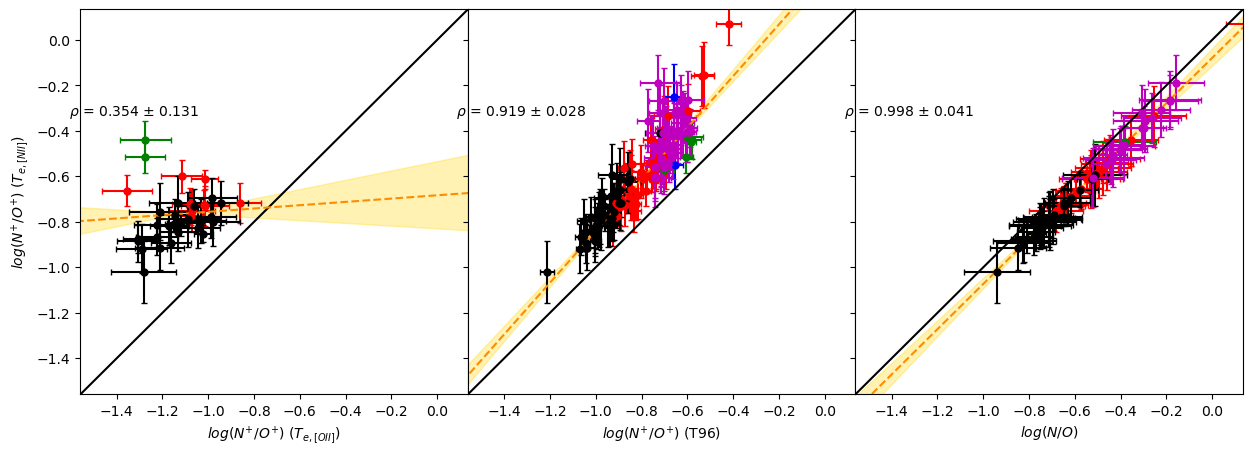

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 5
cap_s = 2
a_val = 1

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr))[0]

    axs[0].errorbar(np.log10(strong_data['N2_ABUN_OII'][plot_ind]), np.log10(strong_data['N2_ABUN_NII'][plot_ind]),
                    xerr=1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind] / strong_data['N2_ABUN_OII'][plot_ind]),
                    yerr=1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind] / strong_data['N2_ABUN_NII'][plot_ind]), 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr))[0]
lim_list = np.concatenate([np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_1]))])

axs[0].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[0].set_ylabel(r'$log(N^{+}/O^{+})$ $(T_{e, [NII]})$')
axs[0].set_xlabel(r'$log(N^{+}/O^{+})$ $(T_{e, [OII]})$')

x, y = np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_1]))
x_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_1] / strong_data['N2_ABUN_OII'][plot_ind_1])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind_1] / strong_data['N2_ABUN_NII'][plot_ind_1])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--') 
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[0].text(-1.61, -0.33, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[0].legend()

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr) & (1 / (np.log(10) * strong_data['NO_t96_err']) > snr))[0]

    axs[1].errorbar(strong_data['NO_t96'][plot_ind], np.log10(strong_data['N2_ABUN_NII'][plot_ind]),
             yerr=1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind] / strong_data['N2_ABUN_NII'][plot_ind]),
             xerr=strong_data['NO_t96_err'][plot_ind], c=colordic[k-1],
             fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_2 = np.where((strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr) & (1 / (np.log(10) * strong_data['NO_t96_err']) > snr))[0]
lim_list = np.concatenate([lim_list, np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_2])), np.array(strong_data['NO_t96'][plot_ind_2])])

axs[1].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[1].set_xlabel(r'$log(N^{+}/O^{+})$ (T96)')

axs[1].set_xlim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)
axs[1].set_ylim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)

x, y = np.array(strong_data['NO_t96'][plot_ind_2]), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_2]))
x_err = np.array(strong_data['NO_t96_err'][plot_ind_2])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind_2] / strong_data['N2_ABUN_NII'][plot_ind_2])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[1].text(-1.61, -0.33, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

plot_ind_3 = np.where((strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]
lim_list = np.concatenate([lim_list, np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_3])), np.array(strong_data['N_T0'][plot_ind_3])])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_NII']/strong_data['N2_ABUN_NII_ERR'] > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

    axs[2].errorbar(strong_data['N_T0'][plot_ind], np.log10(strong_data['N2_ABUN_NII'][plot_ind]),
             yerr=1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind] / strong_data['N2_ABUN_NII'][plot_ind]),
             xerr=strong_data['N_T0_ERR'][plot_ind], c=colordic[k-1],
             fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

axs[2].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[2].set_xlabel(r'$log(N/O)$')

axs[2].set_xlim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)
axs[2].set_ylim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)

x, y = np.array(strong_data['N_T0'][plot_ind_3]), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_3]))
x_err = np.array(strong_data['N_T0_ERR'][plot_ind_3])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind_3] / strong_data['N2_ABUN_NII'][plot_ind_3])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[2].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[2].text(-1.61, -0.33, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Find spearman coefficient for plot above

In [ ]:
x, y = np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_1]))
x_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_1] / strong_data['N2_ABUN_OII'][plot_ind_1])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind_1] / strong_data['N2_ABUN_NII'][plot_ind_1])

print(spear_func(x, y, x_err, y_err))

x, y = np.array(strong_data['NO_t96'][plot_ind_2]), np.log10(np.array(strong_data['N2_ABUN_NII'][plot_ind_2]))
x_err = np.array(strong_data['NO_t96_err'][plot_ind_2])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_NII_ERR'][plot_ind_2] / strong_data['N2_ABUN_NII'][plot_ind_2])

print(spear_func(x, y, x_err, y_err))

### Figure 13: N/O verus r_eff, O/H

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 5
cap_s = 2
a_val = 1

N_abun = 'N_T0'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr))[0]
    print(galdic[k])
    axs[0].errorbar(strong_data['r_reff'][plot_ind], strong_data[N_abun][plot_ind],
                    yerr= strong_data[N_abun+'_ERR'][plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr))[0]
lim_list = np.array(strong_data[N_abun][plot_ind_1])
#axs[0].set_ylim(np.nanmin(lim_list)*1.5, np.nanmax(lim_list)*0.5)
axs[0].set_ylim(-2, 0)

x, y = np.array(strong_data['r_reff'][plot_ind_1]), np.array(strong_data[N_abun][plot_ind_1])
x_err = np.array([0 for i in range(len(x))])
y_err = np.array(strong_data[N_abun+'_ERR'][plot_ind_1])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

print(fit_slope, fit_slope_err)

axs[0].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)

lim_list = np.array(strong_data['r_reff'][plot_ind_1])
axs[0].set_xlim(np.nanmin(lim_list)*0.75, np.nanmax(lim_list)*1.05)

axs[0].text(0.15, -1.94, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

axs[0].set_ylabel(r'log(N/O)')
axs[0].set_xlabel(r'Galactocentric Radius [r$_{eff}$]')

met, met_err = 'OH_T0_NII', 'OH_T0_NII_ERR'
#met, met_err = 'met_md23', 'met_md23'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]

    axs[1].errorbar(strong_data[met][plot_ind], strong_data[N_abun][plot_ind],
                 yerr= strong_data[N_abun+'_ERR'][plot_ind],
                 xerr=strong_data[met_err][plot_ind], c=colordic[k-1],
                 fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)
    
    print(len(plot_ind))
plot_ind_2 = np.where((1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]
lim_list = np.array(strong_data[met][plot_ind_2])
#axs[1].set_xlim(np.nanmin(lim_list)*0.9, np.nanmax(lim_list)*1.1)
axs[1].set_xlim(7, 9.3)

def nicholls_rel(line_in):
    return np.log10(10**-1.732 + 10**(line_in + 2.19 - 12))

def morisset_rel(line_in):
    return -16.09 + 1.81 * (line_in)

def pilyugin_rel(line_in):
    
    z0 = 8.23 
    
    if line_in < z0:
        val = -1.39 + 0.39(line_in-z0) + 0.30*(line_in-z0)**2
        return val
    
    elif line_in > z0:
        val -1.39 + 1.24(line_in-z0) + 1.63*(line_in-z0)**2
        return val

n_line = np.linspace(6, 9, 20)

axs[1].plot(n_line, nicholls_rel(n_line), c='darkorange', label='Nicholls et al. 2016',
            linewidth=3)

n_line = np.linspace(8.2, 8.7, 20)

axs[1].plot(n_line, np.array([morisset_rel(n_line[i]) for i in range(len(n_line))]), c='purple', label='Morisset et al. 2016',
            linewidth=3)

n_line = np.linspace(7.1, 8.8, 20)

#axs[1].plot(n_line, np.array([pilyugin_rel(n_line[i]) for i in range(len(n_line))]), c='cyan', label='Pilyugin et al. 2012',
 #           linewidth=3)

x, y = np.array(strong_data[met][plot_ind_2]), np.array(strong_data[N_abun][plot_ind_2])
x_err = np.array(strong_data[met_err][plot_ind_2])
y_err = np.array(strong_data[N_abun+'_ERR'][plot_ind_2])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].text(7.05, -1.94, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

axs[1].set_xlabel(r'12+log(O/H) (Benchmark)')
axs[1].legend()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 14: [SIII]/[SII] versus [OIII]/[OII]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 3
cap_s = 1

U_param_o = np.log10(np.array((strong_data['OIII5006_FLUX_CORR'] * 4/3) / strong_data['OII3727_FLUX_CORR']))
U_param_o_err = 1/np.log(10) * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

U_param_s = np.log10(np.array((strong_data['SIII9068_FLUX_CORR'] * 2.47) / (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR'])))
U_param_s_err = 1/np.log(10) * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) *U_param_o_err) > snr) & (1 / (np.log(10) * U_param_s_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs.errorbar(U_param_o[plot_ind], U_param_s[plot_ind],
                 xerr = U_param_o_err[plot_ind],
                 yerr = U_param_s_err[plot_ind], 
                 c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                 label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) *U_param_o_err) > snr) & (1 / (np.log(10) * U_param_s_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

x, y = U_param_o[plot_ind_1], U_param_s[plot_ind_1]
x_err = U_param_o_err[plot_ind_1]
y_err = U_param_s_err[plot_ind_1]

min, max = np.min(np.concatenate([x,y])), np.max(np.concatenate([x,y]))

updown = 1.1
axs.set_xlim(min*updown, max*updown)
axs.set_ylim(min*updown, max*updown)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-2, 2, 100), fit_coef + fit_slope*np.linspace(-2, 2, 100), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-2, 2, 100), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-2, 2, 100), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-2, 2, 100),
                 color='gold', alpha=0.15)

axs.plot(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10), c='k', label='1-1')

#axs.set_xscale('log')
#axs.set_yscale('log')

axs.set_ylabel(r'log([SIII] / [SII])')
axs.set_xlabel(r'log([OIII] / [OII])')
axs.legend(loc='lower right', fontsize = 7)

### Figure 15: Temperature difference versus ionization paramter

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)


snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

U_param_o = np.array((strong_data['OIII5006_FLUX_CORR'] * 4/3) / strong_data['OII3727_FLUX_CORR'])
U_param_o_err = U_param_o * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

U_param_s = np.array((strong_data['SIII9068_FLUX_CORR'] * 2.47) / (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))
U_param_s_err = U_param_s * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

temp_diff = np.array(strong_data['NII_TEMP'] - strong_data['OII_TEMP'])
temp_diff_err = np.array(np.sqrt(strong_data['NII_TEMP_ERR']**2 + strong_data['OII_TEMP_ERR']**2))

### Oxygen ionization parameter

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind) > 0:

        axs[0].errorbar(U_param_o[plot_ind], temp_diff[plot_ind],
                    xerr = U_param_o_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[0].set_ylabel(r'$T_{e, [N II]} - T_{e, [O II]} [K]$', fontsize = 15)
axs[0].set_xlabel(r'[OIII] / [OII]', fontsize = 15)

x, y = U_param_o[plot_ind_1], temp_diff[plot_ind_1]
x_err = U_param_o_err[plot_ind_1]
y_err = temp_diff_err[plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.7, np.nanmax(x)*1.1)
axs[0].set_ylim(np.nanmin(y)*1.4, np.nanmax(y)*1.4)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='lower right', fontsize = 7)

### Sulfur ionization parameter

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind) > 0:

        axs[1].errorbar(U_param_s[plot_ind], temp_diff[plot_ind],
                    xerr = U_param_s_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[1].set_xlabel(r'[SIII] / [SII]', fontsize = 15)

x, y = U_param_s[plot_ind_2], temp_diff[plot_ind_2]
x_err = U_param_s_err[plot_ind_2]
y_err = temp_diff_err[plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*0.7, np.nanmax(x)*1.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[1].text(0.29, -9000, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label = r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='lower right', fontsize = 7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 16: temperatures and the ionization softness paramter

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

n_eta = np.array((np.array(strong_data['OII3727_FLUX_CORR'])/ np.array(strong_data['OIII5006_FLUX_CORR']) * 4/3))
n_eta_err = n_eta * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

d_eta = (np.array(strong_data['SII6716_FLUX_CORR']) + np.array(strong_data['SII6730_FLUX_CORR'])) / (np.array(strong_data['SIII9068_FLUX_CORR']) * 2.47)
d_eta_err = d_eta * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

eta_p = np.log10(n_eta / d_eta)
eta_p_err = (1/np.log(10)) * np.sqrt((d_eta_err/d_eta)**2 + (n_eta_err/n_eta)**2)

temp_diff = strong_data['NII_TEMP'] - strong_data['OII_TEMP']
temp_diff_err = np.sqrt((strong_data['OII_TEMP_ERR']) ** 2 + (strong_data['NII_TEMP_ERR']) ** 2)

### eta prime versus Te([NII])

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_1) > 0:

        axs[0].errorbar(eta_p[plot_ind_1], strong_data['NII_TEMP'][plot_ind_1],
                    xerr = eta_p_err[plot_ind_1],
                    yerr= strong_data['NII_TEMP_ERR'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

axs[0].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[0].set_ylabel(r'$T_{e, [N II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_1], strong_data['NII_TEMP'][plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = strong_data['NII_TEMP_ERR'][plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*1.1, np.nanmax(x)*1.075)
axs[0].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='upper right', fontsize = 7)

### eta prime versus Te([OII])

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_2) > 0:

        axs[1].errorbar(eta_p[plot_ind_2], strong_data['OII_TEMP'][plot_ind_2],
                    xerr = eta_p_err[plot_ind_2],
                    yerr= strong_data['OII_TEMP_ERR'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[1].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[1].set_ylabel(r'$T_{e, [O II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_2], strong_data['OII_TEMP'][plot_ind_2]
x_err = eta_p_err[plot_ind_2]
y_err = strong_data['OII_TEMP_ERR'][plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*1.1, np.nanmax(x)*1.075)
axs[1].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='upper right', fontsize = 7)

### eta prime versus T([NII]) - T([OII])

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_3) > 0:

        axs[2].errorbar(eta_p[plot_ind_3], temp_diff[plot_ind_3],
                    xerr = eta_p_err[plot_ind_3],
                    yerr= temp_diff_err[plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_3 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

axs[2].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[2].set_ylabel(r'$T_{e, [N II]}$ - $T_{e, [O II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_3], temp_diff[plot_ind_3]
x_err = eta_p_err[plot_ind_3]
y_err = temp_diff_err[plot_ind_3]

axs[2].set_xlim(np.nanmin(x) * 0.5, np.nanmax(x)*1.5)
axs[2].set_ylim(np.nanmin(y)*1.5, np.nanmax(y)*1.5)

#axs[2].set_xlim(0, 2)
#axs[2].set_ylim(-2500, 2500)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[2].legend(loc='upper right', fontsize = 7)

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

### Figure 17: log(N/O) versus log($\eta^\prime$)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII]) - n([SII])

tsquare = strong_data['N_T0']
tsquare_err = strong_data['N_T0_ERR']

#tsquare = strong_data['OH_T0_NII']
#tsquare_err = strong_data['OH_T0_NII_ERR']

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

    if len(plot_ind) > 0:

        axs.errorbar(eta_p[plot_ind], tsquare[plot_ind],
                    yerr = tsquare_err[plot_ind],
                    xerr = eta_p_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

x, y = eta_p[plot_ind_1], tsquare[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = tsquare_err[plot_ind_1]

axs.set_xlim(np.nanmin(x)*0.2, np.nanmax(x)*1.22)
axs.set_ylim(np.nanmin(y)*1.2, np.nanmax(y)*0.6)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

#axs.set_ylabel(r"$T_{e, [NII]}$ [K]", fontsize = 15)
axs.set_ylabel(r"log(N/O)", fontsize = 15)
axs.set_xlabel(r"$log(\eta')$", fontsize = 15)
axs.legend(loc='lower right', fontsize=7)

### Figure NEW: 12 + log(O/H) versus log($\eta^\prime$)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII]) - n([SII])

tsquare = strong_data['OH_T0_NII']
tsquare_err = strong_data['OH_T0_NII_ERR']

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

    if len(plot_ind) > 0:

        axs.errorbar(eta_p[plot_ind], tsquare[plot_ind],
                    yerr = tsquare_err[plot_ind],
                    xerr = eta_p_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

x, y = eta_p[plot_ind_1], tsquare[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = tsquare_err[plot_ind_1]

axs.set_xlim(np.nanmin(x)*3, np.nanmax(x)*1.22)
axs.set_ylim(np.nanmin(y)*0.95, np.nanmax(y)*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

#axs.set_ylabel(r"$T_{e, [NII]}$ [K]", fontsize = 15)
axs.set_ylabel(r"12 + log(O/H)", fontsize = 15)
axs.set_xlabel(r"$log(\eta')$", fontsize = 15)
axs.legend(loc='lower right', fontsize=7)

### Figure 18: Compare t^2 with various quantities

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII])

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (strong_data['SII_DEN']/strong_data['SII_DEN_ERR'] > snr))[0]

    if len(plot_ind_1) > 0:

        axs[0].errorbar(np.log10(strong_data['SII_DEN'][plot_ind_1]), strong_data['t^2_MD23'][plot_ind_1],
                    xerr = 1/np.log(10) * (strong_data['SII_DEN_ERR'][plot_ind_1]/strong_data['SII_DEN'][plot_ind_1]),
                    yerr= strong_data['t^2_MD23_ERR'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (strong_data['SII_DEN']/strong_data['SII_DEN_ERR'] > snr))[0]

axs[0].set_ylabel(r'$t^{2}(O^{2+})$', fontsize = 15)
axs[0].set_xlabel(r'$n_{e, [S II]}$ $[log(cm^{-3})]$', fontsize = 15)

x, y = np.log10(strong_data['SII_DEN'][plot_ind_1]), strong_data['t^2_MD23'][plot_ind_1]
x_err = 1/np.log(10) * (strong_data['SII_DEN_ERR'][plot_ind_1]/strong_data['SII_DEN'][plot_ind_1])
y_err = strong_data['t^2_MD23_ERR'][plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.075)
axs[0].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='lower right', fontsize = 7)

### t^2 versus log(N/O)

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (1/ (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

    if len(plot_ind_2) > 0:

        axs[1].errorbar(strong_data['N_T0'][plot_ind_2], strong_data['t^2_MD23'][plot_ind_2],
                    xerr = strong_data['N_T0_ERR'][plot_ind_2],
                    yerr = strong_data['t^2_MD23_ERR'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (1/ (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

axs[1].set_xlabel(r'log(N/O)', fontsize = 15)

x, y = strong_data['N_T0'][plot_ind_2], strong_data['t^2_MD23'][plot_ind_2]
x_err = strong_data['N_T0_ERR'][plot_ind_2]
y_err = strong_data['t^2_MD23_ERR'][plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*1.2, np.nanmax(x)*0.7)
axs[1].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-5, 10, 10), fit_coef + fit_slope*np.linspace(-5, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-5, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='lower right', fontsize = 7)

### t^2 versus ADF proxy

adf_p = strong_data['O3_T0_SII'] / strong_data['O3_SIII_SII']
adf_p_err = np.sqrt((strong_data['O3_T0_SII_ERR'] / strong_data['O3_T0_SII'])**2 + (strong_data['O3_SIII_SII_ERR'] / strong_data['O3_SIII_SII'])**2)

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (adf_p/adf_p_err > snr))[0]

    if len(plot_ind_3) > 0:

        axs[2].errorbar(adf_p[plot_ind_3], strong_data['t^2_MD23'][plot_ind_3],
                    xerr = adf_p_err[plot_ind_3],
                    yerr= strong_data['t^2_MD23_ERR'][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_3 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (adf_p/adf_p_err > snr))[0]

axs[2].set_xlabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [S II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [S II]}\right)}$', fontsize = 15)

x, y = adf_p[plot_ind_3], strong_data['t^2_MD23'][plot_ind_3]
x_err = adf_p_err[plot_ind_3]
y_err = strong_data['t^2_MD23_ERR'][plot_ind_3]

axs[2].set_xlim(np.nanmin(x)*0.5, np.nanmax(x)*1.2)
axs[2].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].plot(np.linspace(-1, 30, 10), fit_coef + fit_slope*np.linspace(-1, 30, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[2].legend(loc='lower right', fontsize = 7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 19: ADF proxy versus density, metallicity and N/O

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

snr = 2
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 20

adf = np.array(strong_data['O3_T0_SII'] / strong_data['O3_SIII_SII'])
adf_err = adf * np.sqrt((strong_data['O3_T0_SII_ERR'] / strong_data['O3_T0_SII'])**2 + (strong_data['O3_SIII_SII_ERR'] / strong_data['O3_SIII_SII'])**2)

den = np.array(np.log10(strong_data['SII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['SII_DEN_ERR'] / strong_data['SII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[0].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[0].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[0].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[0].set_xlabel(r"$n_{e, [S II]}$ $[log(cm^{-3}]$)", fontsize = label_size)
axs[0].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]7325+/3727+}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]7325+/3727+}\right)}$', fontsize = label_size + 5)
axs[0].legend(loc='upper left', fontsize=12)

den = np.array(np.log10(strong_data['OII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['OII_DEN_ERR'] / strong_data['OII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[1].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[1].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[1].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[1].set_xlabel(r"$n_{e, [OII]7325+/3727+}$ $[log(cm^{-3}]$", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[1].legend(loc='upper left', fontsize=12)

in_met = 'met_md23'

met = np.array(strong_data[in_met])
met_err = np.array(strong_data[in_met + '_err'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * met_err) > 3) & (adf/adf_err > 3))[0]

    if len(plot_ind) > 0:

        axs[2].errorbar(met[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = met_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((1 / (np.log(10) * met_err) > 3) & (adf/adf_err > 3))[0]

x, y = met[plot_ind_1], adf[plot_ind_1]
x_err = met_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[2].set_xlim(np.nanmin(x)*0.99, np.nanmax(x)*1.01)
axs[2].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[2].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[2].set_xlabel(r"MD23" + '\n' + r"[12 + log(O/H)]", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[2].legend(loc='upper left', fontsize=12)

no = np.array(strong_data['N_T0'])
no_err = np.array(strong_data['N_T0_ERR'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * no_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[3].errorbar(no[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = no_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * no_err) > snr))[0]

x, y = no[plot_ind_1], adf[plot_ind_1]
x_err = no_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[3].set_xlim(np.nanmin(x)*1.2, np.nanmax(x)*0.8)
axs[3].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[3].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[3].set_xlabel(r"log(N/O)", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[3].legend(loc='upper left', fontsize=12)


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 20: Strong Line versus Direct metallicities

In [ ]:
snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15
legend_size = 7.75
spear_dec = 2

met_labs = np.array(['met_scal', 'met_rcal', 'met_rs2Dcal', 'met_kk04'])

met_label_dict = {'met_scal':'PG16-Scal', 'met_rcal':'PG16-Rcal', 'met_rs2Dcal':'PG16-RScal', 'met_kk04':'KK04'}

fig, axs = plt.subplots(len(met_label_dict), 4, figsize=(20, 5*len(met_label_dict)), sharey=True, sharex=True)

lim_list = []

for j in range(len(met_labs)):
    
    met_in, met_in_err = met_labs[j], met_labs[j]+'_err'
    plt_lab = met_label_dict[met_labs[j]]

    ### MD23

    for k in range(2, len(galdic)+1):

        plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_1) > 0:
        
            axs[j][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data[met_in_err][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    axs[j][0].set_ylabel(f'{plt_lab} [12 + log(O/H)]', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][0].set_xlabel(r'MD23 [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1]
    x_err = strong_data['met_md23_err'][plot_ind_1]
    y_err = strong_data[met_in_err][plot_ind_1]

    axs[j][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs.text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][0].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(Benchmark)

    for k in range(2, len(galdic)+1):

        plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_NII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_2) > 0:
        
            axs[j][1].errorbar(strong_data['OH_T0_NII'][plot_ind_2], strong_data[met_in][plot_ind_2],
                    xerr = strong_data['OH_T0_NII_ERR'][plot_ind_2],
                    yerr = strong_data[met_in_err][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_NII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][1].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][1].set_xlabel(r'$O^{+}$ $\left(T_{e, [NII]}, n_{e, [SII]}, [OII]\lambda3727 \right)$' + '\n' + r'$O^{2+}$ $\left(T_{0}(O^{2+}), n_{e, [SII]}\right)$' + '\n' + r"[12 + log(O/H)]", fontsize = label_size)

    x, y = strong_data['OH_T0_NII'][plot_ind_2], strong_data[met_in][plot_ind_2]
    x_err = strong_data['OH_T0_NII_ERR'][plot_ind_2]
    y_err = strong_data[met_in_err][plot_ind_2]

    axs[j][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][1].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(MUSE)

    for k in range(2, len(galdic)+1):

        plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_3) > 0:
        
            axs[j][2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data[met_in_err][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][2].set_xlabel(r'MUSE [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3]
    x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
    y_err = strong_data[met_in_err][plot_ind_3]

    axs[j][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][2].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(t^2 > 0)

    for k in range(2, len(galdic)+1):

        plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_7325_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_4) > 0:
        
            axs[j][3].errorbar(strong_data['OH_7325'][plot_ind_4], strong_data[met_in][plot_ind_4],
                    xerr = strong_data['OH_7325_ERR'][plot_ind_4],
                    yerr = strong_data[met_in_err][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

    plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_7325_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][3].set_xlabel(r'$T_{e, [SIII]}$ [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_7325'][plot_ind_4], strong_data[met_in][plot_ind_4]
    x_err = strong_data['OH_7325_ERR'][plot_ind_4]
    y_err = strong_data[met_in_err][plot_ind_4]

    axs[j][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][3].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)
    lim_arr = np.concatenate(lim_list)
    axs[j][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
    axs[j][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Figure 21: Strong Line versus direct metallicities

In [ ]:
snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15
legend_size = 7.75
spear_dec = 2

met_labs = np.array(['met_m91', 'met_d02', 'met_m13_o3n2', 'met_m13_n2'])

met_label_dict = {'met_m91':'M91', 'met_d02':'D02', 'met_m13_o3n2':'M13-O3N2', 'met_m13_n2':'M13-N2'}

fig, axs = plt.subplots(len(met_label_dict), 4, figsize=(20, 5*len(met_label_dict)), sharey=True, sharex=True)

lim_list = []

for j in range(len(met_labs)):
    
    met_in, met_in_err = met_labs[j], met_labs[j]+'_err'
    plt_lab = met_label_dict[met_labs[j]]

    ### MD23

    for k in range(2, len(galdic)+1):

        plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_1) > 0:
        
            axs[j][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data[met_in_err][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    axs[j][0].set_ylabel(f'{plt_lab} [12 + log(O/H)]', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][0].set_xlabel(r'MD23 [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1]
    x_err = strong_data['met_md23_err'][plot_ind_1]
    y_err = strong_data[met_in_err][plot_ind_1]

    axs[j][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs.text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][0].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(Benchmark)

    for k in range(2, len(galdic)+1):

        plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_2) > 0:
        
            axs[j][1].errorbar(strong_data['OH_T0_OII'][plot_ind_2], strong_data[met_in][plot_ind_2],
                    xerr = strong_data['OH_T0_OII_ERR'][plot_ind_2],
                    yerr = strong_data[met_in_err][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][1].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][1].set_xlabel(r'Benchmark [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_T0_OII'][plot_ind_2], strong_data[met_in][plot_ind_2]
    x_err = strong_data['OH_T0_OII_ERR'][plot_ind_2]
    y_err = strong_data[met_in_err][plot_ind_2]

    axs[j][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][1].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(MUSE)

    for k in range(2, len(galdic)+1):

        plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_3) > 0:
        
            axs[j][2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data[met_in_err][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][2].set_xlabel(r'MUSE [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3]
    x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
    y_err = strong_data[met_in_err][plot_ind_3]

    axs[j][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][2].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(t^2 > 0)

    for k in range(2, len(galdic)+1):

        plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_4) > 0:
        
            axs[j][3].errorbar(strong_data['OH_SIII_OII'][plot_ind_4], strong_data[met_in][plot_ind_4],
                    xerr = strong_data['OH_SIII_OII_ERR'][plot_ind_4],
                    yerr = strong_data[met_in_err][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

    plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][3].set_xlabel(r'$T_{e, [SIII]}$ [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_SIII_OII'][plot_ind_4], strong_data[met_in][plot_ind_4]
    x_err = strong_data['OH_SIII_OII_ERR'][plot_ind_4]
    y_err = strong_data[met_in_err][plot_ind_4]

    axs[j][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][3].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)
    lim_arr = np.concatenate(lim_list)
    axs[j][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
    axs[j][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()